# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 76.9 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=1981

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping


def map_variables_same_timeline(vars_list, time_identifiers_lst):
  """
  Creates a dictionary that maps each variable to its timeline.
  It will be useful for the feature drop on the testing set due to missing values.

  Args:
      vars_list: list of variable names to be analysed.
      time_identifiers_lst: list of timeline identifiers.

  Returns:
      A dictionary with feature names as keys and their timeline as values.
  """
  # dictionary to store the mapping
  temporal_mapping = {}

  # Assign each chronological variable to its timeline
  for time_id in time_identifiers_lst:
    temporal_cols = [col for col in vars_list if time_id in col]
    for col in temporal_cols:
      temporal_mapping[col] = time_id

  return temporal_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")

**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed


def measure_temporal_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, temporal_vars_family,
  imputation_dict=None, num_feat=25, method='simple', encoded_vars_family=None,
  categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """
  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    print('original removed: ', original_removed)
    print('length original removed: ', len(original_removed))
    print('num feat: ', num_feat)
    print('i: ', i)
    print('length features importance list: ', len(features_importance_list))
    print('length removed: ', len(removed))
    print('')

    if features_importance_list[i] in removed:
      print('Feature already removed: ', features_importance_list[i])
      i = i+1
      continue
    focus_feature = features_importance_list[i]
    print("Removing feature: ", focus_feature)

    if focus_feature in temporal_vars_family.keys():
      timeline = temporal_vars_family[focus_feature]
      related_temporal_features = [k for k,v in temporal_vars_family.items() if v == timeline and k in X_test.columns]
      related_temporal_features = [feat for feat in related_temporal_features if feat not in removed]
    else:
      related_temporal_features = [focus_feature]

    for current_feature in related_temporal_features:
      print('Removing related temporal feature: ', current_feature)
      if encoded_vars_family is not None:
        # all the ohe variables derived from the original category should be set to missing
        if current_feature in encoded_vars_family.keys():
          original_feature = encoded_vars_family[current_feature]
          related_features = [k for k,v in encoded_vars_family.items() if v == original_feature and k in X_test.columns]
          # related features that are still in the model (e.g. logistic regression does not have all feat)
          related_features = [feat for feat in related_features if feat not in removed]
          print("Removing related features: ", related_features)
          removed.extend(related_features)
          original_removed.extend([original_feature])
          for feature in related_features:
            if method == 'simple':
              X_test_new[feature] = imputation_dict[feature]
        else:
          removed.extend([current_feature])
          original_removed.extend([current_feature])
          if method == 'simple':
            X_test_new[current_feature] = imputation_dict[current_feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Columns with zero variance, i.e. imputed:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    original_removed = list(set(original_removed))
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
variable_rename = {
    'ID': 'ID',
    'X1': 'LIMIT_BAL',
    'X2': 'SEX',
    'X3': 'EDUCATION',
    'X4': 'MARRIAGE',
    'X5': 'AGE',
    'X6': 'PAY_STATUS_1M_AGO',
    'X7': 'PAY_STATUS_2M_AGO',
    'X8': 'PAY_STATUS_3M_AGO',
    'X9': 'PAY_STATUS_4M_AGO',
    'X10': 'PAY_STATUS_5M_AGO',
    'X11': 'PAY_STATUS_6M_AGO',
    'X12': 'BILL_AMT_1M_AGO',
    'X13': 'BILL_AMT_2M_AGO',
    'X14': 'BILL_AMT_3M_AGO',
    'X15': 'BILL_AMT_4M_AGO',
    'X16': 'BILL_AMT_5M_AGO',
    'X17': 'BILL_AMT_6M_AGO',
    'X18': 'PAY_AMT_1M_AGO',
    'X19': 'PAY_AMT_2M_AGO',
    'X20': 'PAY_AMT_3M_AGO',
    'X21': 'PAY_AMT_4M_AGO',
    'X22': 'PAY_AMT_5M_AGO',
    'X23': 'PAY_AMT_6M_AGO',
    'Y': 'Target'
}

default_cc, default_cc_variables = load_data_from_ucimlrepo(350, variable_rename_dict=variable_rename)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [ ]:
default_cc.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_STATUS_1M_AGO  \
0      20000    2          2         1   24                  2   
1     120000    2          2         2   26                 -1   
2      90000    2          2         2   34                  0   
3      50000    2          2         1   37                  0   
4      50000    1          2         1   57                 -1   

   PAY_STATUS_2M_AGO  PAY_STATUS_3M_AGO  PAY_STATUS_4M_AGO  PAY_STATUS_5M_AGO  \
0                  2                 -1                 -1                 -2   
1                  2                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                 -1                  0                  0   

   ...  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
0  ...                0                0                0               0   
1  ...             3272             3455             3261               0   
2  ...            14331            14948            15549            1518   
3  ...            28314            28959            29547            2000   
4  ...            20940            19146            19131            2000   

   PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             689               0               0               0   
1            1000            1000            1000               0   
2            1500            1000            1000            1000   
3            2019            1200            1100            1069   
4           36681           10000            9000             689   

   PAY_AMT_6M_AGO  Target  
0               0       1  
1            2000       1  
2            5000       0  
3            1000       0  
4             679       0  

[5 rows x 24 columns]

In [ ]:
default_cc_variables

name     role     type      demographic  \
0                  ID       ID  Integer             None   
1           LIMIT_BAL  Feature  Integer             None   
2                 SEX  Feature  Integer              Sex   
3           EDUCATION  Feature  Integer  Education Level   
4            MARRIAGE  Feature  Integer   Marital Status   
5                 AGE  Feature  Integer              Age   
6   PAY_STATUS_1M_AGO  Feature  Integer             None   
7   PAY_STATUS_2M_AGO  Feature  Integer             None   
8   PAY_STATUS_3M_AGO  Feature  Integer             None   
9   PAY_STATUS_4M_AGO  Feature  Integer             None   
10  PAY_STATUS_5M_AGO  Feature  Integer             None   
11  PAY_STATUS_6M_AGO  Feature  Integer             None   
12    BILL_AMT_1M_AGO  Feature  Integer             None   
13    BILL_AMT_2M_AGO  Feature  Integer             None   
14    BILL_AMT_3M_AGO  Feature  Integer             None   
15    BILL_AMT_4M_AGO  Feature  Integer             None   
16    BILL_AMT_5M_AGO  Feature  Integer             None   
17    BILL_AMT_6M_AGO  Feature  Integer             None   
18     PAY_AMT_1M_AGO  Feature  Integer             None   
19     PAY_AMT_2M_AGO  Feature  Integer             None   
20     PAY_AMT_3M_AGO  Feature  Integer             None   
21     PAY_AMT_4M_AGO  Feature  Integer             None   
22     PAY_AMT_5M_AGO  Feature  Integer             None   
23     PAY_AMT_6M_AGO  Feature  Integer             None   
24             Target   Target   Binary             None   

                   description units missing_values  
0                         None  None             no  
1                    LIMIT_BAL  None             no  
2                          SEX  None             no  
3                    EDUCATION  None             no  
4                     MARRIAGE  None             no  
5                          AGE  None             no  
6                        PAY_0  None             no  
7                        PAY_2  None             no  
8                        PAY_3  None             no  
9                        PAY_4  None             no  
10                       PAY_5  None             no  
11                       PAY_6  None             no  
12                   BILL_AMT1  None             no  
13                   BILL_AMT2  None             no  
14                   BILL_AMT3  None             no  
15                   BILL_AMT4  None             no  
16                   BILL_AMT5  None             no  
17                   BILL_AMT6  None             no  
18                    PAY_AMT1  None             no  
19                    PAY_AMT2  None             no  
20                    PAY_AMT3  None             no  
21                    PAY_AMT4  None             no  
22                    PAY_AMT5  None             no  
23                    PAY_AMT6  None             no  
24  default payment next month  None             no

In [ ]:
default_cc.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS_1M_AGO',
       'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO',
       'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_1M_AGO',
       'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO',
       'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO',
       'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO',
       'PAY_AMT_6M_AGO', 'Target'],
      dtype='object')

## Make feature names and feature values more human-interpretable

The dataset present categories that have no explanation in the original presentation of the dataset. After some research, it was possible to find additional explanation from the authors for these categories, which will be adopted.

- Original definition of the data: https://www.semanticscholar.org/paper/The-comparisons-of-data-mining-techniques-for-the-Yeh-Lien/1cacac4f0ea9fdff3cd88c151c94115a9fddcf33
- Additional explanation of the categories: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

In [ ]:
# Dictionaries for each categorical attribute
SEX = {
    1: 'male',
    2: 'female',
}

EDUCATION = {
    0: 'others',
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',
    6: 'others'
}

MARRIAGE = {
    0: 'others',
    1: 'married',
    2: 'single',
    3: 'divorced'
}

PAY_STATUS = {
    -2: 'no consumption',
    -1: 'paid fully',
    0: 'revolving credit used'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'SEX': SEX,
    'EDUCATION': EDUCATION,
    'MARRIAGE': MARRIAGE,
    'PAY_STATUS_1M_AGO': PAY_STATUS,
    'PAY_STATUS_2M_AGO': PAY_STATUS,
    'PAY_STATUS_3M_AGO': PAY_STATUS,
    'PAY_STATUS_4M_AGO': PAY_STATUS,
    'PAY_STATUS_5M_AGO': PAY_STATUS,
    'PAY_STATUS_6M_AGO': PAY_STATUS
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    default_cc[column] = default_cc[column].map(lambda x: mapping.get(x, x))

default_cc.head()

LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0      20000  female  university  married   24                      2   
1     120000  female  university   single   26             paid fully   
2      90000  female  university   single   34  revolving credit used   
3      50000  female  university  married   37  revolving credit used   
4      50000    male  university  married   57             paid fully   

       PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0                      2             paid fully             paid fully   
1                      2  revolving credit used  revolving credit used   
2  revolving credit used  revolving credit used  revolving credit used   
3  revolving credit used  revolving credit used  revolving credit used   
4  revolving credit used             paid fully  revolving credit used   

       PAY_STATUS_5M_AGO  ... BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  \
0         no consumption  ...               0                0   
1  revolving credit used  ...            3272             3455   
2  revolving credit used  ...           14331            14948   
3  revolving credit used  ...           28314            28959   
4  revolving credit used  ...           20940            19146   

   BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  \
0                0               0             689               0   
1             3261               0            1000            1000   
2            15549            1518            1500            1000   
3            29547            2000            2019            1200   
4            19131            2000           36681           10000   

   PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  PAY_AMT_6M_AGO  Target  
0               0               0               0       1  
1            1000               0            2000       1  
2            1000            1000            5000       0  
3            1100            1069            1000       0  
4            9000             689             679       0  

[5 rows x 24 columns]

## Feature engineering

The features PAY_STATUS_xM_AGO have a different meaning if their value is a number (i.e. nr of months of delay in the payment) or if the value is a text (no delay in the payment).

So each PAY_STATUS_xM_AGO will result in two features:
- PAY_STATUS_xM_AGO: 'no consumption', 'paid fully', 'revolving credit used', 'payment overdue'
- PAY_DELAY_xM_AGO: 1, 2, ..., 9

In [ ]:
for col in default_cc.columns:
  if col.startswith('PAY_STATUS'):
    new_colname = col.replace('STATUS', 'DELAY')
    default_cc[new_colname] = default_cc[col].apply(lambda x: x if isinstance(x, (int, float)) else 0)
    default_cc[col] = default_cc[col].apply(lambda x: 'payment overdue' if isinstance(x, (int, float)) else x)

default_cc

LIMIT_BAL     SEX    EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0          20000  female   university  married   24        payment overdue   
1         120000  female   university   single   26             paid fully   
2          90000  female   university   single   34  revolving credit used   
3          50000  female   university  married   37  revolving credit used   
4          50000    male   university  married   57             paid fully   
...          ...     ...          ...      ...  ...                    ...   
29995     220000    male  high school  married   39  revolving credit used   
29996     150000    male  high school   single   43             paid fully   
29997      30000    male   university   single   37        payment overdue   
29998      80000    male  high school  married   41        payment overdue   
29999      50000    male   university  married   46  revolving credit used   

           PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0            payment overdue             paid fully             paid fully   
1            payment overdue  revolving credit used  revolving credit used   
2      revolving credit used  revolving credit used  revolving credit used   
3      revolving credit used  revolving credit used  revolving credit used   
4      revolving credit used             paid fully  revolving credit used   
...                      ...                    ...                    ...   
29995  revolving credit used  revolving credit used  revolving credit used   
29996             paid fully             paid fully             paid fully   
29997        payment overdue        payment overdue             paid fully   
29998             paid fully  revolving credit used  revolving credit used   
29999  revolving credit used  revolving credit used  revolving credit used   

           PAY_STATUS_5M_AGO  ... PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             no consumption  ...              0               0   
1      revolving credit used  ...           1000               0   
2      revolving credit used  ...           1000            1000   
3      revolving credit used  ...           1100            1069   
4      revolving credit used  ...           9000             689   
...                      ...  ...            ...             ...   
29995  revolving credit used  ...           3047            5000   
29996  revolving credit used  ...            129               0   
29997  revolving credit used  ...           4200            2000   
29998  revolving credit used  ...           1926           52964   
29999  revolving credit used  ...           1000            1000   

       PAY_AMT_6M_AGO  Target  PAY_DELAY_1M_AGO  PAY_DELAY_2M_AGO  \
0                   0       1                 2                 2   
1                2000       1                 0                 2   
2                5000       0                 0                 0   
3                1000       0                 0                 0   
4                 679       0                 0                 0   
...               ...     ...               ...               ...   
29995            1000       0                 0                 0   
29996               0       0                 0                 0   
29997            3100       1                 4                 3   
29998            1804       1                 1                 0   
29999            1000       1                 0                 0   

       PAY_DELAY_3M_AGO  PAY_DELAY_4M_AGO  PAY_DELAY_5M_AGO  PAY_DELAY_6M_AGO  
0                     0                 0                 0                 0  
1                     0                 0                 0                 2  
2                     0                 0                 0                 0  
3                     0                 0                 0                 0  
4                     0                 0                 0                 0  
...    

# **Split data in train and test set**

In [ ]:
default_cc_train, default_cc_test = train_test_split(
    default_cc, test_size=0.2, random_state=RANDOM_STATE, stratify=default_cc['Target']
)
default_cc_train['Target'].value_counts()

Target
0    18691
1     5309
Name: count, dtype: int64

## Variable encoding

In [ ]:
cat_variables = ['SEX', 'EDUCATION', 'MARRIAGE'] + [col for col in default_cc_train.columns if col.startswith('PAY_STATUS')]

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
default_cc_train_encoded, default_cc_ohe = one_hot_encoding(default_cc_train, cat_variables, encoder=None)
default_cc_test_encoded, _ = one_hot_encoding(default_cc_test, cat_variables, encoder=default_cc_ohe)

# move target variable to the end of the dataframe
X_vars = [col for col in default_cc_train_encoded.columns if col != 'Target']
default_cc_train_encoded = default_cc_train_encoded[X_vars + ['Target']]
default_cc_test_encoded = default_cc_test_encoded[X_vars + ['Target']]

default_cc_encoded_vars_family = map_encoded_variables_to_original(default_cc_train_encoded.columns, cat_variables)

Categorical variables:  ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO']


In [ ]:
default_cc_train_encoded.head()

LIMIT_BAL  AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  BILL_AMT_3M_AGO  \
12094      50000   43            10898             8754                0   
21968     120000   28             1613              136                0   
20687     180000   28           175154           175790           153515   
25155      30000   24            29654            28570            31085   
15205     160000   29             6252             5073             6854   

       BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
12094            16475            16821            17220            1000   
21968                0                0                0             136   
20687           130864           131569           128983            5100   
25155            29945            30373            29476               0   
15205             3759             3164             3000            4000   

       PAY_AMT_2M_AGO  ...  PAY_STATUS_4M_AGO_paid fully  \
12094               0  ...                           1.0   
21968               0  ...                           0.0   
20687              50  ...                           0.0   
25155            3300  ...                           0.0   
15205            2230  ...                           0.0   

       PAY_STATUS_4M_AGO_payment overdue  \
12094                                0.0   
21968                                0.0   
20687                                1.0   
25155                                1.0   
15205                                1.0   

       PAY_STATUS_4M_AGO_revolving credit used  PAY_STATUS_5M_AGO_paid fully  \
12094                                      0.0                           0.0   
21968                                      0.0                           0.0   
20687                                      0.0                           0.0   
25155                                      0.0                           0.0   
15205                                      0.0                           0.0   

       PAY_STATUS_5M_AGO_payment overdue  \
12094                                0.0   
21968                                0.0   
20687                                1.0   
25155                                1.0   
15205                                0.0   

       PAY_STATUS_5M_AGO_revolving credit used  PAY_STATUS_6M_AGO_paid fully  \
12094                                      1.0                           0.0   
21968                                      0.0                           0.0   
20687                                      0.0                           0.0   
25155                                      0.0                           0.0   
15205                                      1.0                           0.0   

       PAY_STATUS_6M_AGO_payment overdue  \
12094                                0.0   
21968                                0.0   
20687                                1.0   
25155                                1.0   
15205                                0.0   

       PAY_STATUS_6M_AGO_revolving credit used  Target  
12094                                      1.0       0  
21968                                      0.0       0  
20687                                      0.0       0  
25155                                      0.0       0  
15205                                      1.0       0  

[5 rows x 46 columns]

In [ ]:
default_cc_train_encoded.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment

In [ ]:
default_cc_encoded_vars_family

{'SEX_male': 'SEX',
 'EDUCATION_high school': 'EDUCATION',
 'EDUCATION_others': 'EDUCATION',
 'EDUCATION_university': 'EDUCATION',
 'MARRIAGE_married': 'MARRIAGE',
 'MARRIAGE_others': 'MARRIAGE',
 'MARRIAGE_single': 'MARRIAGE',
 'PAY_STATUS_1M_AGO_paid fully': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_5M_AGO_paid fully': 'PAY_STATUS_5M_AGO',
 'PAY_

Because this dataset has a chronologica factor, it will be interesting to measure the performance decay in terms of timeline feature disruption, i.e. what if the model in production does not have access to the most recent data (i.e. last month, last 2 months, ...)

In [ ]:
temporal_ids = [str(i+1)+'M_AGO' for i in range(6)]
default_cc_timeline_vars_family = map_variables_same_timeline(
    default_cc_train_encoded.columns, temporal_ids
)
default_cc_timeline_vars_family

{'BILL_AMT_1M_AGO': '1M_AGO',
 'PAY_AMT_1M_AGO': '1M_AGO',
 'PAY_DELAY_1M_AGO': '1M_AGO',
 'PAY_STATUS_1M_AGO_paid fully': '1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': '1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': '1M_AGO',
 'BILL_AMT_2M_AGO': '2M_AGO',
 'PAY_AMT_2M_AGO': '2M_AGO',
 'PAY_DELAY_2M_AGO': '2M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': '2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': '2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': '2M_AGO',
 'BILL_AMT_3M_AGO': '3M_AGO',
 'PAY_AMT_3M_AGO': '3M_AGO',
 'PAY_DELAY_3M_AGO': '3M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': '3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': '3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': '3M_AGO',
 'BILL_AMT_4M_AGO': '4M_AGO',
 'PAY_AMT_4M_AGO': '4M_AGO',
 'PAY_DELAY_4M_AGO': '4M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': '4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': '4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': '4M_AGO',
 'BILL_AMT_5M_AGO': '5M_AGO',
 'PAY_AMT_5M_AGO': '5M_AGO',
 

# **Data summary and quality**

In [ ]:
describe_data(default_cc_train_encoded)


Data dimension :
Number of Records :  24000 
Number of Features :  46

Datatype of Features :
float64    25
int64      21
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Number of duplicated records : 26

Data summary :
            LIMIT_BAL           AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  \
count    24000.000000  24000.000000     24000.000000     24000.000000   
mean    167362.653333     35.474042     51282.816875     49231.001458   
std     129908.320367      9.184035     73770.715678     71250.058391   
min      10000.000000     21.000000   -165580.000000    -69777.000000   
25%      50000.000000     28.000000      3485.500000      2927.750000   
50%     140000.000000     34.000000     22420.500000     21190.500000   
75%     240000.000000     41.000000     67100.500000     64129.750000   
max    1000000.000000     79.000000    964511.000000    983931.000000   

       BILL_AMT_3M_AGO  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO

# **Correlation**

In [ ]:
default_cc_train_encoded.dtypes

LIMIT_BAL                                    int64
AGE                                          int64
BILL_AMT_1M_AGO                              int64
BILL_AMT_2M_AGO                              int64
BILL_AMT_3M_AGO                              int64
BILL_AMT_4M_AGO                              int64
BILL_AMT_5M_AGO                              int64
BILL_AMT_6M_AGO                              int64
PAY_AMT_1M_AGO                               int64
PAY_AMT_2M_AGO                               int64
PAY_AMT_3M_AGO                               int64
PAY_AMT_4M_AGO                               int64
PAY_AMT_5M_AGO                               int64
PAY_AMT_6M_AGO                               int64
PAY_DELAY_1M_AGO                             int64
PAY_DELAY_2M_AGO                             int64
PAY_DELAY_3M_AGO                             int64
PAY_DELAY_4M_AGO                             int64
PAY_DELAY_5M_AGO                             int64
PAY_DELAY_6M_AGO                             int64
SEX_male                                   float64
EDUCATION_high school                      float64
EDUCATION_others                           float64
EDUCATION_university                       float64
MARRIAGE_married                           float64
MARRIAGE_others                            float64
MARRIAGE_single                            float64
PAY_STATUS_1M_AGO_paid fully               float64
PAY_STATUS_1M_AGO_payment overdue          float64
PAY_STATUS_1M_AGO_revolving credit used    float64
PAY_STATUS_2M_AGO_paid fully               float64
PAY_STATUS_2M_AGO_payment overdue          float64
PAY_STATUS_2M_AGO_revolving credit used    float64
PAY_STATUS_3M_AGO_paid fully               float64
PAY_STATUS_3M_AGO_payment overdue          float64
PAY_STATUS_3M_AGO_revolving credit used    float64
PAY_STATUS_4M_AGO_paid fully               float64
PAY_STATUS_4M_AGO_payment overdue          float64
PAY_STATUS_4M_AGO_revolving credit used    float64
PAY_STATUS_5M_AGO_paid fully               float64
PAY_STATUS_5M_AGO_payment overdue          float64
PAY_STATUS_5M_AGO_revolving credit used    float64
PAY_STATUS_6M_AGO_paid fully               float64
PAY_STATUS_6M_AGO_payment overdue          float64
PAY_STATUS_6M_AGO_revolving credit used    float64
Target                                       int64
dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

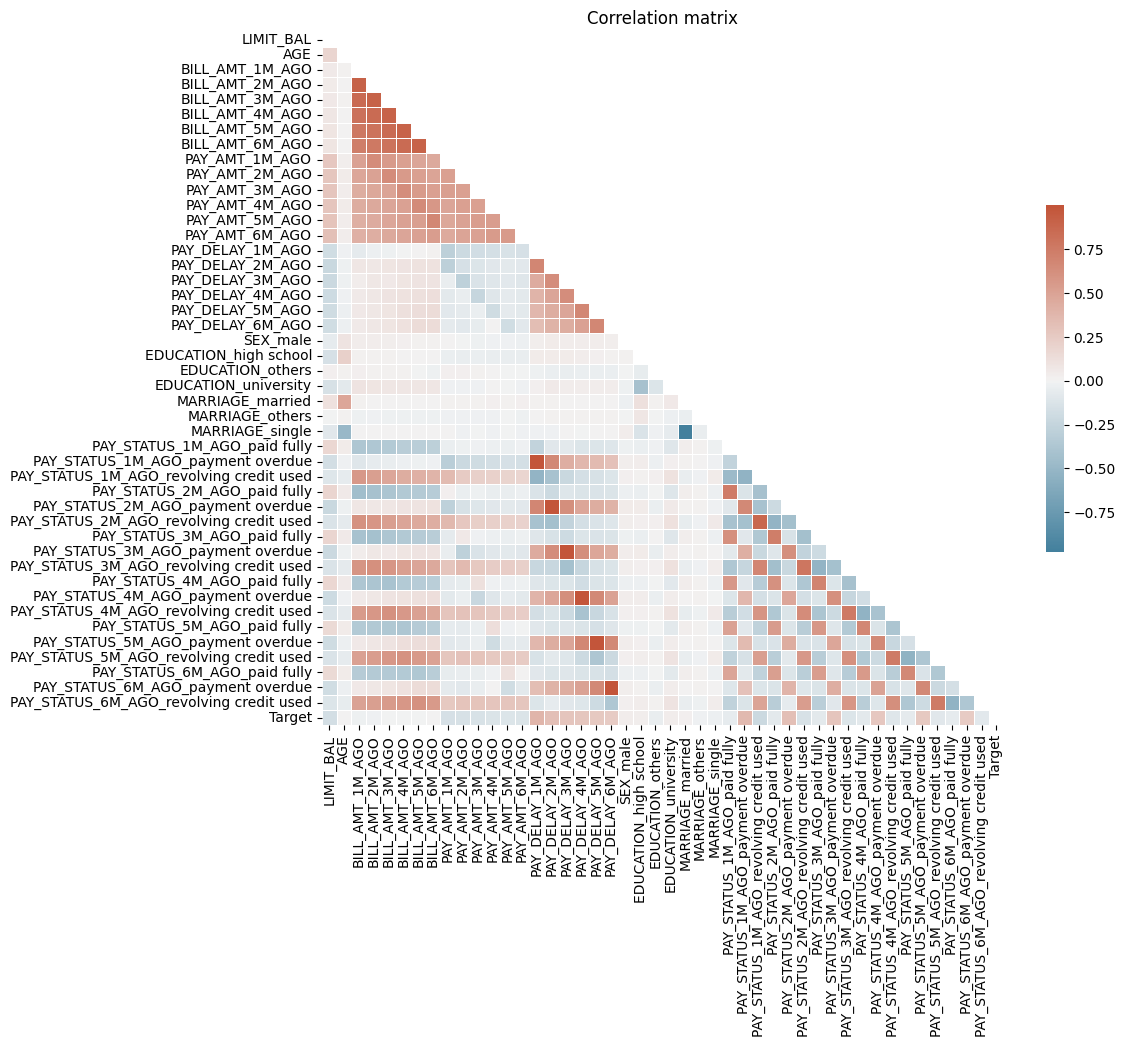

In [ ]:
default_cc_corr = calculate_correlation(default_cc_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(default_cc_corr['Target']).sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.384900
PAY_STATUS_1M_AGO_payment overdue          0.361325
PAY_DELAY_2M_AGO                           0.326266
PAY_STATUS_2M_AGO_payment overdue          0.325452
PAY_DELAY_3M_AGO                           0.287098
PAY_STATUS_3M_AGO_payment overdue          0.286152
PAY_DELAY_4M_AGO                           0.274226
PAY_STATUS_4M_AGO_payment overdue          0.273232
PAY_DELAY_5M_AGO                           0.261017
PAY_STATUS_5M_AGO_payment overdue          0.260116
PAY_DELAY_6M_AGO                           0.244671
PAY_STATUS_6M_AGO_payment overdue          0.243548
PAY_STATUS_1M_AGO_revolving credit used    0.213499
LIMIT_BAL                                  0.166275
PAY_AMT_1M_AGO                             0.154697
PAY_STATUS_2M_AGO_revolving credit used    0.148554
PAY_AMT_2M_AGO                             0.146715
PAY_AMT_3M_AGO                             0.139978
PAY_AMT_4M_AGO                             0.126635
PAY_AMT_6M_AGO                             0.121124
PAY_AMT_5M_AGO                             0.117971
PAY_STATUS_3M_AGO_revolving credit used    0.114844
PAY_STATUS_4M_AGO_revolving credit used    0.099740
PAY_STATUS_5M_AGO_revolving credit used    0.089809
PAY_STATUS_6M_AGO_revolving credit used    0.086837
PAY_STATUS_3M_AGO_paid fully               0.077363
PAY_STATUS_2M_AGO_paid fully               0.075766
PAY_STATUS_4M_AGO_paid fully               0.073429
PAY_STATUS_5M_AGO_paid fully               0.069133
PAY_STATUS_1M_AGO_paid fully               0.064411
PAY_STATUS_6M_AGO_paid fully               0.061600
EDUCATION_others                           0.048298
EDUCATION_university                       0.037097
SEX_male                                   0.036982
EDUCATION_high school                      0.032305
MARRIAGE_single                            0.027821
MARRIAGE_married                           0.026244
BILL_AMT_1M_AGO                            0.025308
BILL_AMT_2M_AGO                            0.014326
MARRIAGE_others                            0.013454
BILL_AMT_3M_AGO                            0.011414
BILL_AMT_4M_AGO                            0.010129
BILL_AMT_5M_AGO                            0.008913
AGE                                        0.001993
BILL_AMT_6M_AGO                            0.001531
Name: Target, dtype: float64

df columns:  Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4

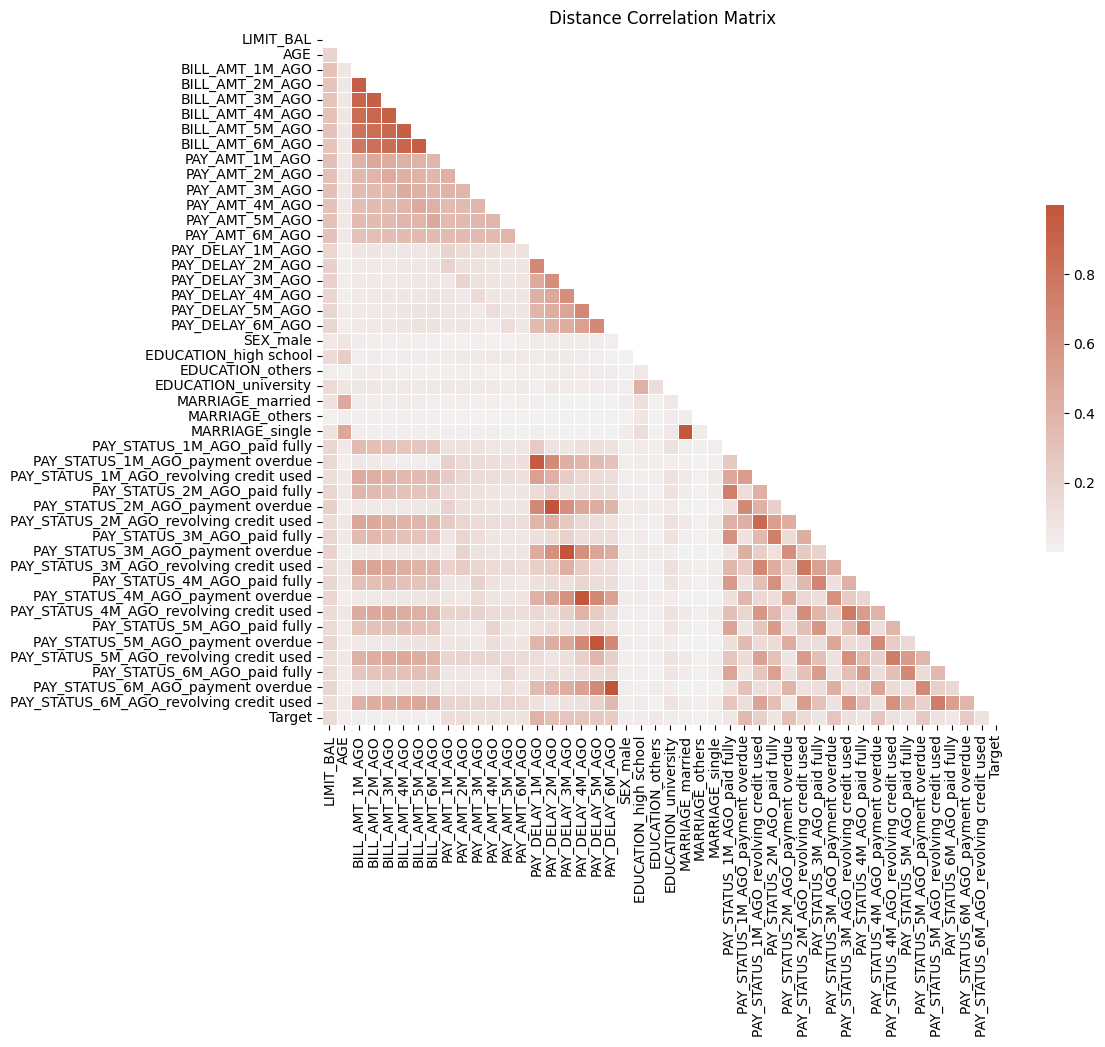

In [ ]:
default_cc_dist_corr = calculate_distance_correlation_matrix(default_cc_train_encoded)

In [ ]:
default_cc_dist_corr['Target'].sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.401849
PAY_STATUS_1M_AGO_payment overdue          0.361325
PAY_DELAY_2M_AGO                           0.326197
PAY_STATUS_2M_AGO_payment overdue          0.325452
PAY_DELAY_3M_AGO                           0.286395
PAY_STATUS_3M_AGO_payment overdue          0.286152
PAY_DELAY_4M_AGO                           0.273534
PAY_STATUS_4M_AGO_payment overdue          0.273232
PAY_DELAY_5M_AGO                           0.260580
PAY_STATUS_5M_AGO_payment overdue          0.260116
PAY_DELAY_6M_AGO                           0.244184
PAY_STATUS_6M_AGO_payment overdue          0.243548
PAY_STATUS_1M_AGO_revolving credit used    0.213499
LIMIT_BAL                                  0.153732
PAY_STATUS_2M_AGO_revolving credit used    0.148554
PAY_AMT_2M_AGO                             0.118876
PAY_AMT_1M_AGO                             0.118822
PAY_STATUS_3M_AGO_revolving credit used    0.114844
PAY_AMT_3M_AGO                             0.107607
PAY_STATUS_4M_AGO_revolving credit used    0.099740
PAY_AMT_4M_AGO                             0.095606
PAY_AMT_5M_AGO                             0.094957
PAY_AMT_6M_AGO                             0.092370
PAY_STATUS_5M_AGO_revolving credit used    0.089809
PAY_STATUS_6M_AGO_revolving credit used    0.086837
PAY_STATUS_3M_AGO_paid fully               0.077363
PAY_STATUS_2M_AGO_paid fully               0.075766
PAY_STATUS_4M_AGO_paid fully               0.073429
PAY_STATUS_5M_AGO_paid fully               0.069133
PAY_STATUS_1M_AGO_paid fully               0.064411
PAY_STATUS_6M_AGO_paid fully               0.061600
EDUCATION_others                           0.048298
EDUCATION_university                       0.037097
SEX_male                                   0.036982
EDUCATION_high school                      0.032305
BILL_AMT_1M_AGO                            0.028081
MARRIAGE_single                            0.027821
AGE                                        0.026424
MARRIAGE_married                           0.026244
BILL_AMT_2M_AGO                            0.021954
BILL_AMT_3M_AGO                            0.019245
BILL_AMT_4M_AGO                            0.017028
BILL_AMT_5M_AGO                            0.016919
BILL_AMT_6M_AGO                            0.015628
MARRIAGE_others                            0.013454
Name: Target, dtype: float64

# **Pre-feature selection + Remove intercorrelated features**
Features with zero-variance will be dropped. In this scenario, intercorrelated features will be dropped as well with only one of the pair remaining.

The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
filtered_features = filter_out_intercorrelated_features(default_cc_dist_corr, 'Target', 0.8)

appended feature:  PAY_DELAY_1M_AGO
eliminated feature:  PAY_STATUS_1M_AGO_payment overdue 0.9601537558986976
appended feature:  PAY_DELAY_2M_AGO
eliminated feature:  PAY_STATUS_2M_AGO_payment overdue 0.9976632389218033
appended feature:  PAY_DELAY_3M_AGO
eliminated feature:  PAY_STATUS_3M_AGO_payment overdue 0.9986562162604087
appended feature:  PAY_DELAY_4M_AGO
eliminated feature:  PAY_STATUS_4M_AGO_payment overdue 0.9980311533270702
appended feature:  PAY_DELAY_5M_AGO
eliminated feature:  PAY_STATUS_5M_AGO_payment overdue 0.997705460763519
appended feature:  PAY_DELAY_6M_AGO
eliminated feature:  PAY_STATUS_6M_AGO_payment overdue 0.9981924439263611
appended feature:  PAY_STATUS_1M_AGO_revolving credit used
eliminated feature:  PAY_STATUS_2M_AGO_revolving credit used 0.8708329853634604
appended feature:  LIMIT_BAL
appended feature:  PAY_AMT_2M_AGO
appended feature:  PAY_AMT_1M_AGO
appended feature:  PAY_STATUS_3M_AGO_revolving credit used
appended feature:  PAY_AMT_3M_AGO
appended fea

In [ ]:
print('Original number of features: ', len(default_cc.columns))
print('Original number of encoded features: ', len(default_cc_train_encoded.columns))
print('Number of features after removal of intercorrelated: ', len(filtered_features))

Original number of features:  30
Original number of encoded features:  46
Number of features after removal of intercorrelated:  33


In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

default_cc_zero_variance_columns = identify_zero_variance_columns(default_cc_train_encoded[filtered_features])

if DROP_WEAK_FEATURES:
  default_cc_weak_features = identify_weak_associated_features(
      default_cc_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  default_cc_weak_features = []

remove_columns = set(default_cc_zero_variance_columns + default_cc_weak_features)
remove_columns = [col for col in remove_columns if col in filtered_features]
print(remove_columns)

default_cc_train = default_cc_train_encoded[filtered_features + ['Target']].drop(columns=remove_columns)
default_cc_test = default_cc_test_encoded[filtered_features + ['Target']].drop(columns=remove_columns)

Variance of each column:
PAY_DELAY_1M_AGO                           5.763706e-01
PAY_DELAY_2M_AGO                           6.400466e-01
PAY_DELAY_3M_AGO                           6.234998e-01
PAY_DELAY_4M_AGO                           5.704064e-01
PAY_DELAY_5M_AGO                           5.108973e-01
PAY_DELAY_6M_AGO                           5.075231e-01
PAY_STATUS_1M_AGO_revolving credit used    2.499170e-01
LIMIT_BAL                                  1.687617e+10
PAY_AMT_2M_AGO                             4.266821e+08
PAY_AMT_1M_AGO                             2.831953e+08
PAY_STATUS_3M_AGO_revolving credit used    2.492881e-01
PAY_AMT_3M_AGO                             3.296769e+08
PAY_STATUS_4M_AGO_revolving credit used    2.476500e-01
PAY_AMT_4M_AGO                             2.650750e+08
PAY_AMT_5M_AGO                             2.339204e+08
PAY_AMT_6M_AGO                             3.157077e+08
PAY_STATUS_5M_AGO_revolving credit used    2.458822e-01
PAY_STATUS_6M_AGO_revol

In [ ]:
default_cc_train.head()

PAY_DELAY_1M_AGO  PAY_DELAY_2M_AGO  PAY_DELAY_3M_AGO  PAY_DELAY_4M_AGO  \
12094               0.0               0.0               0.0               0.0   
21968               0.0               0.0               0.0               0.0   
20687               2.0               2.0               2.0               2.0   
25155               1.0               2.0               2.0               2.0   
15205               0.0               0.0               0.0               2.0   

       PAY_DELAY_5M_AGO  PAY_DELAY_6M_AGO  \
12094               0.0               0.0   
21968               0.0               0.0   
20687               2.0               2.0   
25155               2.0               2.0   
15205               0.0               0.0   

       PAY_STATUS_1M_AGO_revolving credit used  LIMIT_BAL  PAY_AMT_2M_AGO  \
12094                                      1.0    50000.0             0.0   
21968                                      0.0   120000.0             0.0   
20687                                      0.0   180000.0            50.0   
25155                                      0.0    30000.0          3300.0   
15205                                      1.0   160000.0          2230.0   

       PAY_AMT_1M_AGO  ...  EDUCATION_others  EDUCATION_university  SEX_male  \
12094          1000.0  ...               0.0                   0.0       1.0   
21968           136.0  ...               0.0                   1.0       0.0   
20687          5100.0  ...               0.0                   0.0       1.0   
25155             0.0  ...               0.0                   1.0       0.0   
15205          4000.0  ...               0.0                   1.0       0.0   

       EDUCATION_high school  BILL_AMT_1M_AGO  MARRIAGE_single   AGE  \
12094                    1.0          10898.0              0.0  43.0   
21968                    0.0           1613.0              0.0  28.0   
20687                    0.0         175154.0              1.0  28.0   
25155                    0.0          29654.0              0.0  24.0   
15205                    0.0           6252.0              0.0  29.0   

       BILL_AMT_6M_AGO  MARRIAGE_others  Target  
12094          17220.0              0.0     0.0  
21968              0.0              0.0     0.0  
20687         128983.0              0.0     0.0  
25155          29476.0              0.0     0.0  
15205           3000.0              0.0     0.0  

[5 rows x 34 columns]

In [ ]:
print('Original number of features: ', len(default_cc.columns))
print('Number of features after pre-feature selection: ', len(default_cc_train.columns))

Original number of features:  30
Number of features after pre-feature selection:  34


# **Imbalanced dataset**

In [ ]:
X_train = default_cc_train.drop('Target', axis=1)
y_train = default_cc_train['Target']

X_test = default_cc_test.drop('Target', axis=1)
y_test = default_cc_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0     18691    0.778792
1.0      5309    0.221208

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
default_cc_imputation_values_dict = calculate_imputation_values_for_missing(
    default_cc_train
)
default_cc_imputation_values_dict

{'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'PAY_STATUS_1M_AGO_revolving credit used': 0.0,
 'LIMIT_BAL': 140000.0,
 'PAY_AMT_2M_AGO': 2003.0,
 'PAY_AMT_1M_AGO': 2100.0,
 'PAY_STATUS_3M_AGO_revolving credit used': 1.0,
 'PAY_AMT_3M_AGO': 1800.0,
 'PAY_STATUS_4M_AGO_revolving credit used': 1.0,
 'PAY_AMT_4M_AGO': 1500.0,
 'PAY_AMT_5M_AGO': 1500.0,
 'PAY_AMT_6M_AGO': 1500.0,
 'PAY_STATUS_5M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_6M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_3M_AGO_paid fully': 0.0,
 'PAY_STATUS_2M_AGO_paid fully': 0.0,
 'PAY_STATUS_4M_AGO_paid fully': 0.0,
 'PAY_STATUS_5M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_6M_AGO_paid fully': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_high school': 0.0,
 'BILL_AMT_1M_AGO': 22420.5,
 'MARRIAGE_single': 1.0,
 'AGE': 34.0,
 'BILL_AMT_6

In [ ]:
default_cc_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
default_cc_cat_vars

['PAY_STATUS_1M_AGO_revolving credit used',
 'PAY_STATUS_3M_AGO_revolving credit used',
 'PAY_STATUS_4M_AGO_revolving credit used',
 'PAY_STATUS_5M_AGO_revolving credit used',
 'PAY_STATUS_6M_AGO_revolving credit used',
 'PAY_STATUS_3M_AGO_paid fully',
 'PAY_STATUS_2M_AGO_paid fully',
 'PAY_STATUS_4M_AGO_paid fully',
 'PAY_STATUS_5M_AGO_paid fully',
 'PAY_STATUS_1M_AGO_paid fully',
 'PAY_STATUS_6M_AGO_paid fully',
 'EDUCATION_others',
 'EDUCATION_university',
 'SEX_male',
 'EDUCATION_high school',
 'MARRIAGE_single',
 'MARRIAGE_others']

In [ ]:
# Maximum number of original features (after feature engineering) to be imputed
NUM_FEAT = 20

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [4],
    'min_samples_split': [0.05],
    'min_samples_leaf': [1]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:05:57.067155

Nested Cross-validation Results:
Individual scores: [0.52768563 0.51737862 0.5126393 ]
Average nested CV score: 0.519 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.519
2025-01-18 18:05:57.799075

Execution time: 0.01 minutes




```
Starting hyperparameter tuning at: 2025-01-16 20:37:24.837891

Nested Cross-validation Results:
Individual scores: [0.52046784 0.50901264 0.50658404]
Average nested CV score: 0.512 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.519
2025-01-16 20:38:06.718128

Execution time: 0.70 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0               PAY_DELAY_1M_AGO    0.126278  0.003408
3               PAY_DELAY_4M_AGO    0.033553  0.001233
2               PAY_DELAY_3M_AGO    0.019525  0.001305
20  PAY_STATUS_4M_AGO_paid fully    0.014038  0.002132
24              EDUCATION_others    0.003526  0.000455
8                 PAY_AMT_2M_AGO   -0.001240  0.001356

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

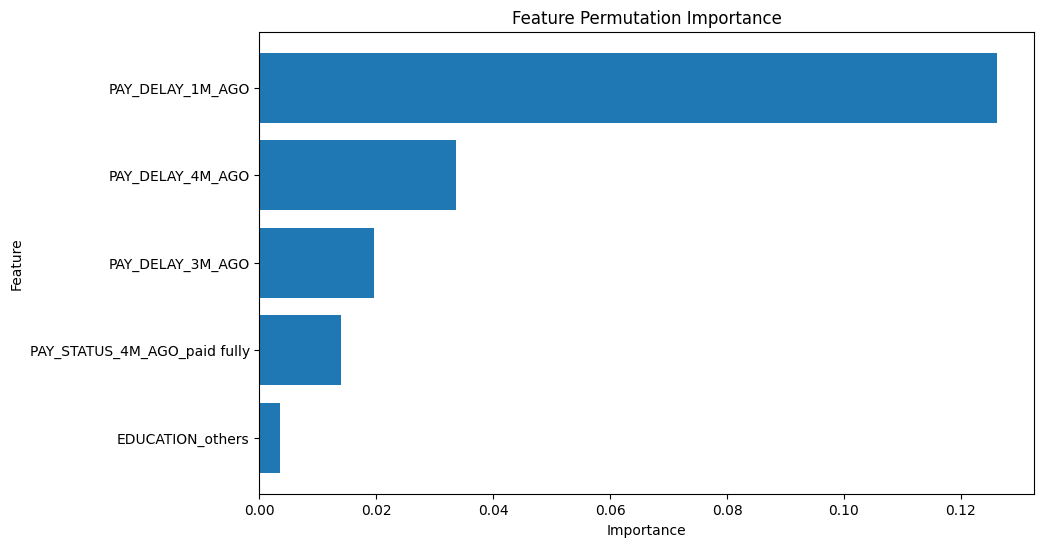

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  EDUCATION_others
Removing related features:  ['EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_4M_AGO', 'EDUCATION']

--- NEW ITERATION ---
Removing feat

In [ ]:
dt_orig_missing

['PAY_DELAY_1M_AGO',
 'PAY_DELAY_4M_AGO',
 'PAY_DELAY_3M_AGO',
 'PAY_STATUS_4M_AGO',
 'EDUCATION',
 'PAY_STATUS_6M_AGO',
 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_5M_AGO',
 'PAY_STATUS_1M_AGO',
 'SEX',
 'BILL_AMT_6M_AGO',
 'BILL_AMT_1M_AGO',
 'MARRIAGE',
 'AGE',
 'PAY_AMT_5M_AGO',
 'PAY_AMT_3M_AGO',
 'PAY_DELAY_2M_AGO',
 'PAY_AMT_1M_AGO',
 'LIMIT_BAL']

In [ ]:
len(dt_missing)

28

In [ ]:
dt_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   801  3846  827   526      49.20   60.36        82.30     77.45     54.21   
1   527  4186  487   800      51.97   39.71        89.58     78.55     45.02   
2   307  4394  279  1020      52.39   23.13        94.03     78.35     32.10   
3     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.33                 0   
1               64.65                 1   
2               58.58                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:06:06.009222

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
dt_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   801  3846  827   526      49.20   60.36        82.30     77.45     54.21   
1   697  3920  753   630      48.07   52.52        83.89     76.95     50.20   
2   669  3989  684   658      49.45   50.41        85.36     77.63     49.93   
3   608  4130  543   719      52.82   45.82        88.38     78.97     49.07   
4   624  4116  557   703      52.84   47.02        88.08     79.00     49.76   
5   626  4110  563   701      52.65   47.17        87.95     78.93     49.76   
6   623  4100  573   704      52.09   46.95        87.74     78.72     49.39   
7   643  4081  592   684      52.06   48.46        87.33     78.73     50.20   
8   644  4081  592   683      52.10   48.53        87.33     78.75     50.25   
9   644  4081  592   683      52.10   48.53        87.33     78.75     50.25   
10  644  4081  592   683      52.10   48.53        87.33     78.75     50.25   
11  644  4081  592   683      52.10   48.53        87.33     78.75     50.25   
12  629  4126  547   698      53.49   47.40        88.29     79.25     50.26   
13  592  4215  458   735      56.38   44.61        90.20     80.12     49.81   
14  592  4215  458   735      56.38   44.61        90.20     80.12     49.81   
15  599  4212  461   728      56.51   45.14        90.13     80.18     50.19   
16  605  4201  472   722      56.17   45.59        89.90     80.10     50.33   
17  605  4191  482   722      55.66   45.59        89.69     79.93     50.12   
18  259  4462  211  1068      55.11   19.52        95.48     78.68     28.83   
19  256  4488  185  1071      58.05   19.29        96.04     79.07     28.96   
20  261  4516  157  1066      62.44   19.67        96.64     79.62     29.91   

    balanced_accuracy  num_feat_missing  \
0               71.33                 0   
1               68.21                 1   
2               67.89                 2   
3               67.10                 3   
4               67.55                 4   
5               67.56                 5   
6               67.34                 6   
7               67.89                 7   
8               67.93                 8   
9               67.93                 9   
10              67.93                10   
11              67.93                11   
12              67.85                12   
13              67.41                13   
14              67.41                14   
15              67.64                15   
16              67.75                16   
17              67.64                17   
18              57.50                18   
19              57.67                19   
20              58.15                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
dt_perf_temp, dt_orig_missing_temp, dt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
dt_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  801  3846  827   526      49.20   60.36        82.30     77.45     54.21   
1  527  4186  487   800      51.97   39.71        89.58     78.55     45.02   
2  307  4394  279  1020      52.39   23.13        94.03     78.35     32.10   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.33                 0   
1              64.65                 4   
2              58.58                 7   
3              50.00                10   
4              50.00                11   
5              50.00                15   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_temp_mf, dt_orig_missing_temp_mf, dt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:11:03.842573

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
dt_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  801  3846  827   526      49.20   60.36        82.30     77.45     54.21   
1  653  4047  626   674      51.06   49.21        86.60     78.33     50.12   
2  643  4080  593   684      52.02   48.46        87.31     78.72     50.18   
3  593  4244  429   734      58.02   44.69        90.82     80.62     50.49   
4  594  4241  432   733      57.89   44.76        90.76     80.58     50.49   
5  561  4283  390   766      58.99   42.28        91.65     80.73     49.25   
6   46  4625   48  1281      48.94    3.47        98.97     77.85      6.47   
7   25  4641   32  1302      43.86    1.88        99.32     77.77      3.61   

   balanced_accuracy  num_feat_missing  \
0              71.33                 0   
1              67.91                 4   
2              67.88                 7   
3              67.75                10   
4              67.76                11   
5              66.96                15   
6              51.22                18   
7              50.60                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [300],
      'max_features': ['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:12:37.591930

Nested Cross-validation Results:
Individual scores: [0.55686893 0.53474801 0.53498812]
Average nested CV score: 0.542 (+/- 0.021)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.542
2025-01-18 18:13:09.515412

Execution time: 0.53 minutes


```
Starting hyperparameter tuning at: 2025-01-17 00:56:57.457635

Nested Cross-validation Results:
Individual scores: [0.5502008  0.53241961 0.53777545]
Average nested CV score: 0.540 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.542
2025-01-17 02:12:16.022611

Execution time: 75.31 minutes
```

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.088269  0.002544
11                           PAY_AMT_3M_AGO    0.026456  0.001025
13                           PAY_AMT_4M_AGO    0.025146  0.001535
28                          BILL_AMT_1M_AGO    0.024871  0.000437
9                            PAY_AMT_1M_AGO    0.024077  0.002039
7                                 LIMIT_BAL    0.023991  0.002011
31                          BILL_AMT_6M_AGO    0.019093  0.000755
8                            PAY_AMT_2M_AGO    0.017868  0.001173
15                           PAY_AMT_6M_AGO    0.015400  0.000612
14                           PAY_AMT_5M_AGO    0.012991  0.000943
30                                      AGE    0.009394  0.000577
6   PAY_STATUS_1M_AGO_revolving credit used    0.007168  0.000626
2                          PAY_DELAY_3M_AGO    0.006880  0.000738
3                          PAY_DELAY_4M_AGO    0.005530  0.000493
10  PAY_STATUS_3M_AGO_revolving credit used    0.004967  0.000506
25                     EDUCATION_university    0.004620  0.000348
18             PAY_STATUS_3M_AGO_paid fully    0.004278  0.000236
23             PAY_STATUS_6M_AGO_paid fully    0.004091  0.000251
22             PAY_STATUS_1M_AGO_paid fully    0.003790  0.000597
29                          MARRIAGE_single    0.003690  0.000652
16  PAY_STATUS_5M_AGO_revolving credit used    0.003069  0.000525
26                                 SEX_male    0.002940  0.000515
12  PAY_STATUS_4M_AGO_revolving credit used    0.002791  0.000614
19             PAY_STATUS_2M_AGO_paid fully    0.002776  0.000396
17  PAY_STATUS_6M_AGO_revolving credit used    0.002689  0.000511
1                          PAY_DELAY_2M_AGO    0.002383  0.001816
20             PAY_STATUS_4M_AGO_paid fully    0.002326  0.000292
21             PAY_STATUS_5M_AGO_paid fully    0.002006  0.000537
24                         EDUCATION_others    0.001777  0.000352
27                    EDUCATION_high school    0.001441  0.000155
4                          PAY_DELAY_5M_AGO    0.001162  0.000258
5                          PAY_DELAY_6M_AGO    0.000205  0.000404
32                          MARRIAGE_others   -0.000020  0.000025

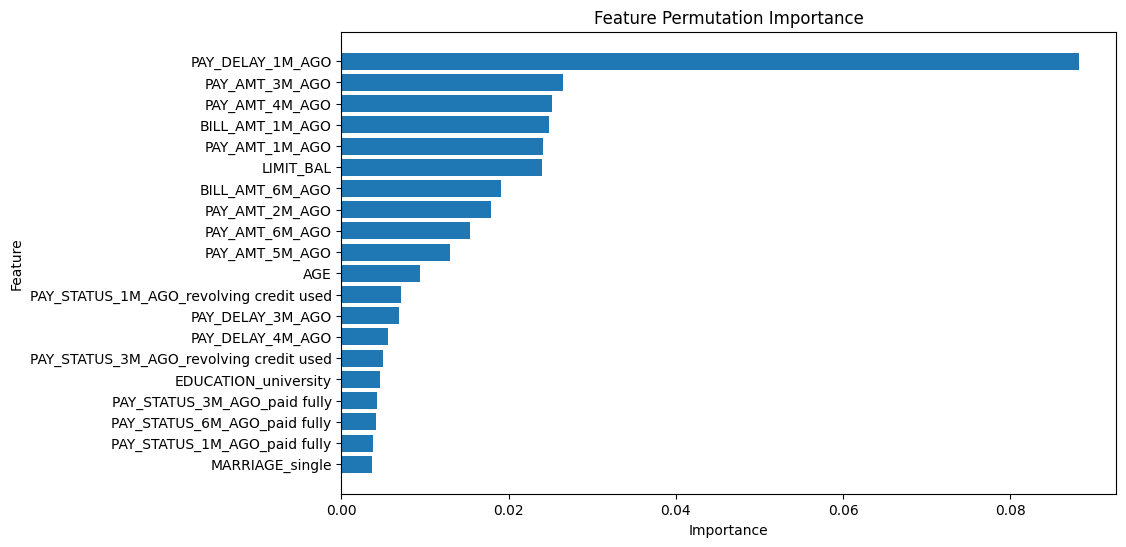

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_6M_AGO
Original feat removed 

In [ ]:
rf_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   812  3943  730   515      52.66   61.19        84.38     79.25     56.61   
1   690  4078  595   637      53.70   52.00        87.27     79.47     52.83   
2   605  4216  457   722      56.97   45.59        90.22     80.35     50.65   
3   598  4226  447   729      57.22   45.06        90.43     80.40     50.42   
4   585  4264  409   742      58.85   44.08        91.25     80.82     50.41   
5   550  4293  380   777      59.14   41.45        91.87     80.72     48.74   
6   504  4352  321   823      61.09   37.98        93.13     80.93     46.84   
7   505  4351  322   822      61.06   38.06        93.11     80.93     46.89   
8   508  4353  320   819      61.35   38.28        93.15     81.02     47.15   
9   510  4351  322   817      61.30   38.43        93.11     81.02     47.24   
10  509  4347  326   818      60.96   38.36        93.02     80.93     47.09   
11  508  4346  327   819      60.84   38.28        93.00     80.90     46.99   
12  516  4320  353   811      59.38   38.88        92.45     80.60     46.99   
13  425  4399  274   902      60.80   32.03        94.14     80.40     41.95   
14  331  4480  193   996      63.17   24.94        95.87     80.18     35.76   
15  346  4466  207   981      62.57   26.07        95.57     80.20     36.81   
16  346  4466  207   981      62.57   26.07        95.57     80.20     36.81   
17  333  4479  194   994      63.19   25.09        95.85     80.20     35.92   
18  328  4490  183   999      64.19   24.72        96.08     80.30     35.69   
19  302  4527  146  1025      67.41   22.76        96.88     80.48     34.03   
20  301  4529  144  1026      67.64   22.68        96.92     80.50     33.97   

    balanced_accuracy  num_feat_missing  \
0               72.78                 0   
1               69.63                 1   
2               67.91                 2   
3               67.75                 3   
4               67.67                 4   
5               66.66                 5   
6               65.56                 6   
7               65.58                 7   
8               65.72                 8   
9               65.77                 9   
10              65.69                10   
11              65.64                11   
12              65.67                12   
13              63.08                13   
14              60.41                14   
15              60.82                15   
16              60.82                16   
17              60.47                17   
18              60.40                18   
19              59.82                19   
20              59.80                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2      ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
4   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
5   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
6   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
7   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
8   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
9   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
10  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
11  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
12  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
13  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
14  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
15  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
16  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
17  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
18  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
19  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
20  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:13:41.359793

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
rf_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   812  3943  730  515      52.66   61.19        84.38     79.25     56.61   
1   725  3989  684  602      51.45   54.63        85.36     78.57     53.00   
2   683  4068  605  644      53.03   51.47        87.05     79.18     52.24   
3   634  4170  503  693      55.76   47.78        89.24     80.07     51.46   
4   621  4202  471  706      56.87   46.80        89.92     80.38     51.34   
5   610  4235  438  717      58.21   45.97        90.63     80.75     51.37   
6   599  4233  440  728      57.65   45.14        90.58     80.53     50.63   
7   608  4224  449  719      57.52   45.82        90.39     80.53     51.01   
8   605  4225  448  722      57.45   45.59        90.41     80.50     50.84   
9   602  4229  444  725      57.55   45.37        90.50     80.52     50.74   
10  604  4215  458  723      56.87   45.52        90.20     80.32     50.57   
11  600  4226  447  727      57.31   45.21        90.43     80.43     50.55   
12  595  4230  443  732      57.32   44.84        90.52     80.42     50.32   
13  584  4255  418  743      58.28   44.01        91.05     80.65     50.15   
14  506  4348  325  821      60.89   38.13        93.05     80.90     46.90   
15  436  4402  271  891      61.67   32.86        94.20     80.63     42.87   
16  391  4429  244  936      61.57   29.46        94.78     80.33     39.86   
17  381  4440  233  946      62.05   28.71        95.01     80.35     39.26   
18  381  4440  233  946      62.05   28.71        95.01     80.35     39.26   
19  369  4451  222  958      62.44   27.81        95.25     80.33     38.48   
20  369  4451  222  958      62.44   27.81        95.25     80.33     38.48   

    balanced_accuracy  num_feat_missing  \
0               72.78                 0   
1               70.00                 1   
2               69.26                 2   
3               68.51                 3   
4               68.36                 4   
5               68.30                 5   
6               67.86                 6   
7               68.10                 7   
8               68.00                 8   
9               67.93                 9   
10              67.86                10   
11              67.82                11   
12              67.68                12   
13              67.53                13   
14              65.59                14   
15              63.53                15   
16              62.12                16   
17              61.86                17   
18              61.86                18   
19              61.53                19   
20              61.53                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2      ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
4   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
5   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
6   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
7   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
8   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
9   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
10  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
11  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
12  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
13  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
14  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
15  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
16  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
17  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
18  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
19  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
20  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...

In [ ]:
rf_perf_temp, rf_orig_missing_temp, rf_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
rf_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  812  3943  730   515      52.66   61.19        84.38     79.25     56.61   
1  582  4205  468   745      55.43   43.86        89.99     79.78     48.97   
2  504  4308  365   823      58.00   37.98        92.19     80.20     45.90   
3  470  4361  312   857      60.10   35.42        93.32     80.52     44.57   
4  358  4460  213   969      62.70   26.98        95.44     80.30     37.72   
5  272  4554  119  1055      69.57   20.50        97.45     80.43     31.66   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.78                 0   
1              66.92                 4   
2              65.08                 7   
3              64.37                10   
4              61.21                11   
5              58.98                15   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_temp_mf, rf_orig_missing_temp_mf, rf_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:18:10.624618

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
rf_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  812  3943  730   515      52.66   61.19        84.38     79.25     56.61   
1  584  4224  449   743      56.53   44.01        90.39     80.13     49.49   
2  559  4287  386   768      59.15   42.13        91.74     80.77     49.21   
3  496  4356  317   831      61.01   37.38        93.22     80.87     46.36   
4  494  4349  324   833      60.39   37.23        93.07     80.72     46.06   
5  498  4356  317   829      61.10   37.53        93.22     80.90     46.50   
6  159  4568  105  1168      60.23   11.98        97.75     78.78     19.99   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.78                 0   
1              67.20                 4   
2              66.93                 7   
3              65.30                10   
4              65.15                11   
5              65.37                15   
6              54.87                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

3.520625353173856

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [1],
      'min_split_gain': [1.0],
      'reg_lambda': [5.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:19:48.576298

Nested Cross-validation Results:
Individual scores: [0.54614834 0.53355705 0.52596475]
Average nested CV score: 0.535 (+/- 0.017)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 1, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.535
2025-01-18 18:19:52.654554

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-16 20:38:06.738789

Nested Cross-validation Results:
Individual scores: [0.54073715 0.52803067 0.523945  ]
Average nested CV score: 0.531 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 1, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.535
2025-01-16 20:47:37.275299

Execution time: 9.51 minutes
```

In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.092919  0.001894
2                          PAY_DELAY_3M_AGO    0.009940  0.000898
7                                 LIMIT_BAL    0.008674  0.002242
28                          BILL_AMT_1M_AGO    0.006933  0.001060
1                          PAY_DELAY_2M_AGO    0.003987  0.001318
3                          PAY_DELAY_4M_AGO    0.003946  0.000806
24                         EDUCATION_others    0.003809  0.000640
11                           PAY_AMT_3M_AGO    0.002470  0.000878
8                            PAY_AMT_2M_AGO    0.002298  0.001123
31                          BILL_AMT_6M_AGO    0.002110  0.000538
22             PAY_STATUS_1M_AGO_paid fully    0.001931  0.000451
30                                      AGE    0.001334  0.000167
5                          PAY_DELAY_6M_AGO    0.001305  0.000151
20             PAY_STATUS_4M_AGO_paid fully    0.001096  0.000321
4                          PAY_DELAY_5M_AGO    0.001000  0.000777
29                          MARRIAGE_single    0.000824  0.000697
26                                 SEX_male    0.000670  0.000508
32                          MARRIAGE_others    0.000629  0.000181
15                           PAY_AMT_6M_AGO    0.000530  0.000614
18             PAY_STATUS_3M_AGO_paid fully    0.000462  0.000134
6   PAY_STATUS_1M_AGO_revolving credit used    0.000374  0.000374
17  PAY_STATUS_6M_AGO_revolving credit used    0.000197  0.000135
21             PAY_STATUS_5M_AGO_paid fully    0.000091  0.000256
14                           PAY_AMT_5M_AGO    0.000036  0.000168
13                           PAY_AMT_4M_AGO    0.000009  0.001794
25                     EDUCATION_university   -0.000064  0.000328
9                            PAY_AMT_1M_AGO   -0.000647  0.000425

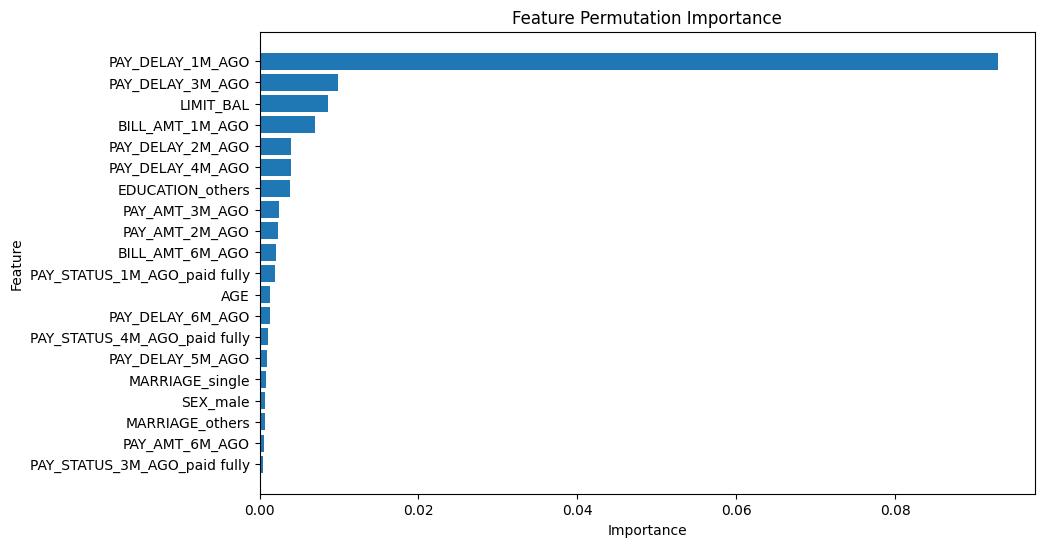

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  EDUCATION_others
Removing relat

In [ ]:
gbt_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   868  3732  941   459      47.98   65.41        79.86     76.67     55.36   
1   671  3937  736   656      47.69   50.57        84.25     76.80     49.09   
2   564  4026  647   763      46.57   42.50        86.15     76.50     44.44   
3   481  4133  540   846      47.11   36.25        88.44     76.90     40.97   
4   295  4506  167  1032      63.85   22.23        96.43     80.02     32.98   
5   204  4545  128  1123      61.45   15.37        97.26     79.15     24.59   
6    49  4652   21  1278      70.00    3.69        99.55     78.35      7.02   
7    49  4653   20  1278      71.01    3.69        99.57     78.37      7.02   
8    18  4665    8  1309      69.23    1.36        99.83     78.05      2.66   
9    12  4668    5  1315      70.59    0.90        99.89     78.00      1.79   
10   24  4666    7  1303      77.42    1.81        99.85     78.17      3.53   
11   22  4667    6  1305      78.57    1.66        99.87     78.15      3.25   
12   20  4669    4  1307      83.33    1.51        99.91     78.15      2.96   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.64                 0   
1               67.41                 1   
2               64.33                 2   
3               62.35                 3   
4               59.33                 4   
5               56.32                 5   
6               51.62                 6   
7               51.63                 7   
8               50.59                 8   
9               50.40                 9   
10              50.83                10   
11              50.76                11   
12              50.71                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:19:56.932090

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
gbt_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    868  3732   941  459      47.98   65.41        79.86     76.67     55.36   
1   1098  2224  2449  229      30.96   82.74        47.59     55.37     45.06   
2   1184  1600  3073  143      27.81   89.22        34.24     46.40     42.41   
3   1178  1519  3154  149      27.19   88.77        32.51     44.95     41.63   
4   1142  1680  2993  185      27.62   86.06        35.95     47.03     41.82   
5   1130  1667  3006  197      27.32   85.15        35.67     46.62     41.37   
6   1229   999  3674   98      25.07   92.61        21.38     37.13     39.45   
7   1233   942  3731   94      24.84   92.92        20.16     36.25     39.20   
8   1237   920  3753   90      24.79   93.22        19.69     35.95     39.16   
9   1026  1773  2900  301      26.13   77.32        37.94     46.65     39.06   
10  1161  1109  3564  166      24.57   87.49        23.73     37.83     38.37   
11  1175  1109  3564  152      24.79   88.55        23.73     38.07     38.74   
12  1175  1072  3601  152      24.60   88.55        22.94     37.45     38.51   
13  1293   439  4234   34      23.39   97.44         9.39     28.87     37.73   
14  1293   439  4234   34      23.39   97.44         9.39     28.87     37.73   
15  1303   254  4419   24      22.77   98.19         5.44     25.95     36.97   
16  1304   247  4426   23      22.76   98.27         5.29     25.85     36.96   
17  1302   264  4409   25      22.80   98.12         5.65     26.10     37.00   
18  1316   149  4524   11      22.53   99.17         3.19     24.42     36.72   
19  1320   119  4554    7      22.47   99.47         2.55     23.98     36.66   
20  1321   122  4551    6      22.50   99.55         2.61     24.05     36.70   

    balanced_accuracy  num_feat_missing  \
0               72.64                 0   
1               65.17                 1   
2               61.73                 2   
3               60.64                 3   
4               61.00                 4   
5               60.41                 5   
6               57.00                 6   
7               56.54                 7   
8               56.45                 8   
9               57.63                 9   
10              55.61                10   
11              56.14                11   
12              55.74                12   
13              53.42                13   
14              53.42                14   
15              51.81                15   
16              51.78                16   
17              51.88                17   
18              51.18                18   
19              51.01                19   
20              51.08                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_3M_AGO', 'LIMI...

In [ ]:
gbt_perf_temp, gbt_orig_missing_temp, gbt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
gbt_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  868  3732  941   459      47.98   65.41        79.86     76.67     55.36   
1  468  4317  356   859      56.80   35.27        92.38     79.75     43.51   
2  323  4476  197  1004      62.12   24.34        95.78     79.98     34.98   
3  227  4552  121  1100      65.23   17.11        97.41     79.65     27.10   
4  220  4548  125  1107      63.77   16.58        97.33     79.47     26.32   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.64                 0   
1              63.82                 4   
2              60.06                 7   
3              57.26                 8   
4              56.95                11   
5              50.00                14   
6              50.00                15   
7              50.00                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_temp_mf, gbt_orig_missing_temp_mf, gbt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:24:42.123893

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
gbt_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   868  3732   941  459      47.98   65.41        79.86     76.67     55.36   
1   910  3081  1592  417      36.37   68.58        65.93     66.52     47.53   
2  1048  2210  2463  279      29.85   78.98        47.29     54.30     43.32   
3  1102  1992  2681  225      29.13   83.04        42.63     51.57     43.13   
4   925  2617  2056  402      31.03   69.71        56.00     59.03     42.94   
5  1036  1780  2893  291      26.37   78.07        38.09     46.93     39.42   
6  1053  1650  3023  274      25.83   79.35        35.31     45.05     38.98   
7  1316    56  4617   11      22.18   99.17         1.20     22.87     36.25   
8  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              72.64                 0   
1              67.25                 4   
2              63.13                 7   
3              62.84                 8   
4              62.85                11   
5              58.08                14   
6              57.33                15   
7              50.18                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'reg_lambda':[0.5],
      'gamma': [0.1],
      'colsample_bytree':[0.5]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:26:30.712649

Nested Cross-validation Results:
Individual scores: [0.55227755 0.52548833 0.52994297]
Average nested CV score: 0.536 (+/- 0.023)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.536
2025-01-18 18:26:33.626723

Execution time: 0.05 minutes


```
Starting hyperparameter tuning at: 2025-01-16 20:47:37.302118

Nested Cross-validation Results:
Individual scores: [0.54623451 0.52579035 0.527394  ]
Average nested CV score: 0.533 (+/- 0.019)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.536
2025-01-16 21:06:59.141319

Execution time: 19.36 minutes
```

In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.079046  0.002618
28                          BILL_AMT_1M_AGO    0.016736  0.001692
7                                 LIMIT_BAL    0.010185  0.001870
2                          PAY_DELAY_3M_AGO    0.008469  0.000607
1                          PAY_DELAY_2M_AGO    0.004915  0.000969
24                         EDUCATION_others    0.004833  0.001229
8                            PAY_AMT_2M_AGO    0.004109  0.001136
3                          PAY_DELAY_4M_AGO    0.004045  0.000802
11                           PAY_AMT_3M_AGO    0.003550  0.001610
31                          BILL_AMT_6M_AGO    0.002618  0.001072
4                          PAY_DELAY_5M_AGO    0.002149  0.000742
29                          MARRIAGE_single    0.000722  0.000332
32                          MARRIAGE_others    0.000576  0.000173
19             PAY_STATUS_2M_AGO_paid fully    0.000539  0.000128
25                     EDUCATION_university    0.000525  0.000546
10  PAY_STATUS_3M_AGO_revolving credit used    0.000482  0.000233
30                                      AGE    0.000459  0.000515
21             PAY_STATUS_5M_AGO_paid fully    0.000346  0.000187
5                          PAY_DELAY_6M_AGO    0.000312  0.000576
12  PAY_STATUS_4M_AGO_revolving credit used    0.000293  0.000393
22             PAY_STATUS_1M_AGO_paid fully    0.000191  0.001234
9                            PAY_AMT_1M_AGO    0.000188  0.001434
23             PAY_STATUS_6M_AGO_paid fully   -0.000131  0.000387
18             PAY_STATUS_3M_AGO_paid fully   -0.000172  0.000495
26                                 SEX_male   -0.000314  0.000431
14                           PAY_AMT_5M_AGO   -0.000315  0.000690
6   PAY_STATUS_1M_AGO_revolving credit used   -0.001115  0.000495
13                           PAY_AMT_4M_AGO   -0.001204  0.001195
15                           PAY_AMT_6M_AGO   -0.001410  0.001298

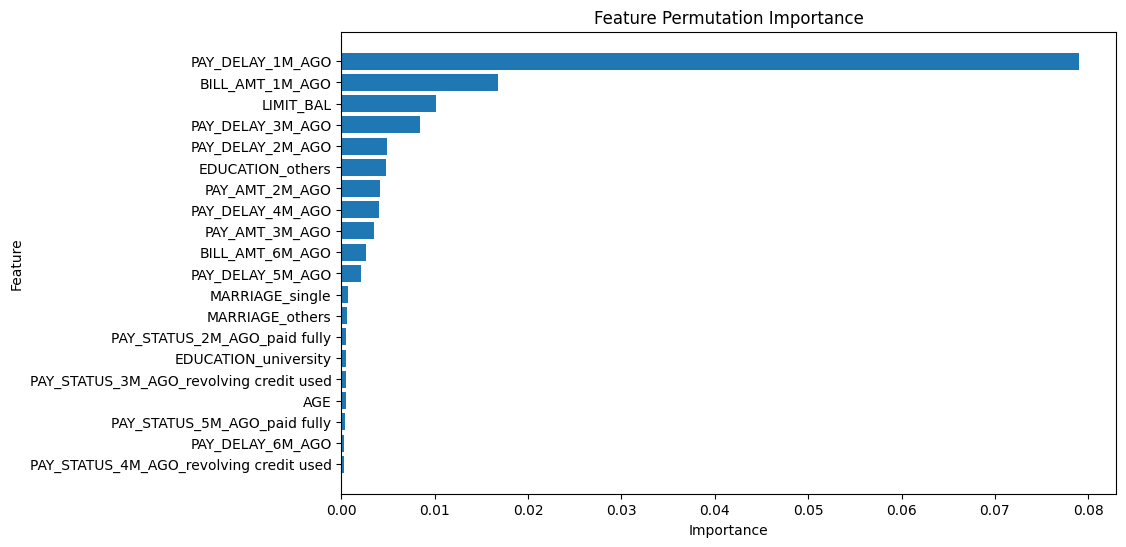

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  EDUCATION_others
Removing related features:  ['EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_2M_AGO

In [ ]:
xgb_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   864  3736  937   463      47.97   65.11        79.95     76.67     55.24   
1   697  3929  744   630      48.37   52.52        84.08     77.10     50.36   
2   546  4279  394   781      58.09   41.15        91.57     80.42     48.17   
3   494  4356  317   833      60.91   37.23        93.22     80.83     46.21   
4   369  4455  218   958      62.86   27.81        95.33     80.40     38.56   
5   262  4516  157  1065      62.53   19.74        96.64     79.63     30.01   
6   262  4520  153  1065      63.13   19.74        96.73     79.70     30.08   
7   260  4518  155  1067      62.65   19.59        96.68     79.63     29.85   
8   102  4618   55  1225      64.97    7.69        98.82     78.67     13.75   
9    59  4634   39  1268      60.20    4.45        99.17     78.22      8.28   
10   62  4638   35  1265      63.92    4.67        99.25     78.33      8.71   
11    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.53                 0   
1               68.30                 1   
2               66.36                 2   
3               65.22                 3   
4               61.57                 4   
5               58.19                 5   
6               58.23                 6   
7               58.14                 7   
8               53.25                 8   
9               51.81                 9   
10              51.96                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:26:36.175039

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
xgb_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   864  3736  937   463      47.97   65.11        79.95     76.67     55.24   
1   748  3871  802   579      48.26   56.37        82.84     76.98     52.00   
2   673  4028  645   654      51.06   50.72        86.20     78.35     50.89   
3   653  4087  586   674      52.70   49.21        87.46     79.00     50.90   
4   629  4140  533   698      54.13   47.40        88.59     79.48     50.54   
5   408  4304  369   919      52.51   30.75        92.10     78.53     38.78   
6   414  4304  369   913      52.87   31.20        92.10     78.63     39.24   
7   316  4396  277  1011      53.29   23.81        94.07     78.53     32.92   
8   176  4512  161  1151      52.23   13.26        96.55     78.13     21.15   
9   112  4614   59  1215      65.50    8.44        98.74     78.77     14.95   
10  109  4599   74  1218      59.56    8.21        98.42     78.47     14.44   
11   15  4671    2  1312      88.24    1.13        99.96     78.10      2.23   
12   14  4671    2  1313      87.50    1.06        99.96     78.08      2.08   
13   14  4671    2  1313      87.50    1.06        99.96     78.08      2.08   
14   13  4672    1  1314      92.86    0.98        99.98     78.08      1.94   
15   13  4673    0  1314     100.00    0.98       100.00     78.10      1.94   
16   13  4673    0  1314     100.00    0.98       100.00     78.10      1.94   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.53                 0   
1               69.60                 1   
2               68.46                 2   
3               68.33                 3   
4               68.00                 4   
5               61.42                 5   
6               61.65                 6   
7               58.94                 7   
8               54.91                 8   
9               53.59                 9   
10              53.32                10   
11              50.54                11   
12              50.51                12   
13              50.51                13   
14              50.48                14   
15              50.49                15   
16              50.49                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
xgb_perf_temp, xgb_orig_missing_temp, xgb_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
xgb_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  864  3736  937   463      47.97   65.11        79.95     76.67     55.24   
1  521  4294  379   806      57.89   39.26        91.89     80.25     46.79   
2  472  4387  286   855      62.27   35.57        93.88     80.98     45.28   
3  268  4541  132  1059      67.00   20.20        97.18     80.15     31.04   
4  207  4564  109  1120      65.51   15.60        97.67     79.52     25.20   
5  206  4567  106  1121      66.03   15.52        97.73     79.55     25.14   
6   25  4660   13  1302      65.79    1.88        99.72     78.08      3.66   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.53                 0   
1              65.58                 4   
2              64.72                 5   
3              58.69                 8   
4              56.63                11   
5              56.63                12   
6              50.80                15   
7              50.00                19   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_temp_mf, xgb_orig_missing_temp_mf, xgb_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:31:10.779673

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
xgb_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  864  3736  937   463      47.97   65.11        79.95     76.67     55.24   
1  611  4184  489   716      55.55   46.04        89.54     79.92     50.35   
2  607  4214  459   720      56.94   45.74        90.18     80.35     50.73   
3  570  4281  392   757      59.25   42.95        91.61     80.85     49.80   
4  243  4537  136  1084      64.12   18.31        97.09     79.67     28.49   
5  244  4535  138  1083      63.87   18.39        97.05     79.65     28.55   
6   83  4629   44  1244      65.35    6.25        99.06     78.53     11.42   
7   44  4649   24  1283      64.71    3.32        99.49     78.22      6.31   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.53                 0   
1              67.79                 4   
2              67.96                 5   
3              67.28                 8   
4              57.70                11   
5              57.72                12   
6              52.66                15   
7              51.40                19   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [300],
      'max_depth': [None],
      'max_features':[0.5],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:32:59.823497

Nested Cross-validation Results:
Individual scores: [0.54214464 0.52938197 0.52329749]
Average nested CV score: 0.532 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.532
2025-01-18 18:33:33.387967

Execution time: 0.56 minutes


CV (3,3)
```
Starting hyperparameter tuning at: 2025-01-17 00:07:02.283303

Nested Cross-validation Results:
Individual scores: [0.53694332 0.52881699 0.52648221]
Average nested CV score: 0.531 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.532
2025-01-17 00:53:49.677979

Execution time: 46.79 minutes
```

In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.088650  0.001891
7                                 LIMIT_BAL    0.039412  0.001471
6   PAY_STATUS_1M_AGO_revolving credit used    0.031045  0.001723
1                          PAY_DELAY_2M_AGO    0.028317  0.002531
17  PAY_STATUS_6M_AGO_revolving credit used    0.027531  0.001014
28                          BILL_AMT_1M_AGO    0.021661  0.001074
31                          BILL_AMT_6M_AGO    0.019535  0.000913
10  PAY_STATUS_3M_AGO_revolving credit used    0.019147  0.001205
3                          PAY_DELAY_4M_AGO    0.016597  0.001346
2                          PAY_DELAY_3M_AGO    0.015668  0.001122
30                                      AGE    0.015468  0.000752
26                                 SEX_male    0.015202  0.001084
9                            PAY_AMT_1M_AGO    0.014969  0.001952
25                     EDUCATION_university    0.014798  0.000657
8                            PAY_AMT_2M_AGO    0.014440  0.000834
11                           PAY_AMT_3M_AGO    0.014319  0.002163
13                           PAY_AMT_4M_AGO    0.013311  0.001421
19             PAY_STATUS_2M_AGO_paid fully    0.013213  0.001228
16  PAY_STATUS_5M_AGO_revolving credit used    0.012982  0.001900
12  PAY_STATUS_4M_AGO_revolving credit used    0.012167  0.000878
14                           PAY_AMT_5M_AGO    0.011732  0.000818
18             PAY_STATUS_3M_AGO_paid fully    0.011604  0.000768
29                          MARRIAGE_single    0.011066  0.000820
22             PAY_STATUS_1M_AGO_paid fully    0.010964  0.000660
15                           PAY_AMT_6M_AGO    0.010917  0.000786
20             PAY_STATUS_4M_AGO_paid fully    0.010551  0.001140
23             PAY_STATUS_6M_AGO_paid fully    0.008961  0.000892
27                    EDUCATION_high school    0.008229  0.000759
21             PAY_STATUS_5M_AGO_paid fully    0.006252  0.000953
5                          PAY_DELAY_6M_AGO    0.005389  0.000600
24                         EDUCATION_others    0.004553  0.001044
4                          PAY_DELAY_5M_AGO    0.004536  0.000319
32                          MARRIAGE_others    0.000650  0.000239

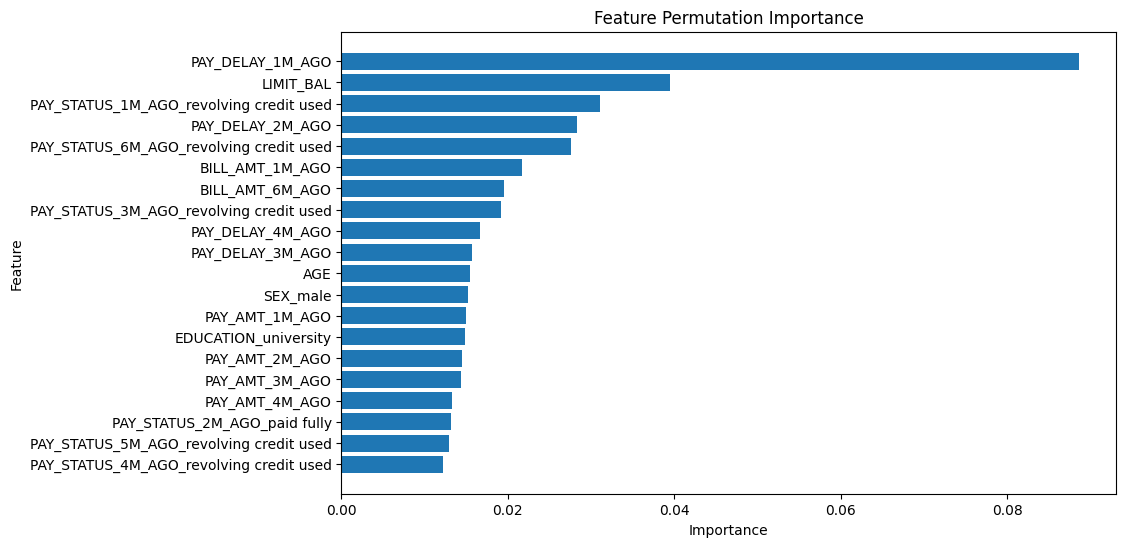

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---

In [ ]:
et_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   819  3863  810   508      50.28   61.72        82.67     78.03     55.41   
1   703  3997  676   624      50.98   52.98        85.53     78.33     51.96   
2   665  4101  572   662      53.76   50.11        87.76     79.43     51.87   
3   659  4078  595   668      52.55   49.66        87.27     78.95     51.07   
4   446  4260  413   881      51.92   33.61        91.16     78.43     40.81   
5   416  4323  350   911      54.31   31.35        92.51     78.98     39.75   
6   420  4330  343   907      55.05   31.65        92.66     79.17     40.19   
7   418  4329  344   909      54.86   31.50        92.64     79.12     40.02   
8   426  4325  348   901      55.04   32.10        92.55     79.18     40.55   
9   309  4498  175  1018      63.84   23.29        96.26     80.12     34.12   
10  256  4555  118  1071      68.45   19.29        97.47     80.18     30.10   
11  246  4561  112  1081      68.72   18.54        97.60     80.12     29.20   
12  207  4577   96  1120      68.32   15.60        97.95     79.73     25.40   
13  216  4576   97  1111      69.01   16.28        97.92     79.87     26.34   
14  242  4548  125  1085      65.94   18.24        97.33     79.83     28.57   
15  252  4541  132  1075      65.62   18.99        97.18     79.88     29.46   
16  253  4540  133  1074      65.54   19.07        97.15     79.88     29.54   
17  254  4540  133  1073      65.63   19.14        97.15     79.90     29.64   
18  256  4538  135  1071      65.47   19.29        97.11     79.90     29.80   
19  146  4590   83  1181      63.76   11.00        98.22     78.93     18.77   
20   68  4638   35  1259      66.02    5.12        99.25     78.43      9.51   

    balanced_accuracy  num_feat_missing  \
0               72.19                 0   
1               69.26                 1   
2               68.94                 2   
3               68.46                 3   
4               62.39                 4   
5               61.93                 5   
6               62.16                 6   
7               62.07                 7   
8               62.33                 8   
9               59.77                 9   
10              58.38                10   
11              58.07                11   
12              56.77                12   
13              57.10                13   
14              57.78                14   
15              58.08                15   
16              58.11                16   
17              58.15                17   
18              58.20                18   
19              54.61                19   
20              52.19                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:34:08.871155

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
et_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   819  3863  810   508      50.28   61.72        82.67     78.03     55.41   
1   735  3905  768   592      48.90   55.39        83.57     77.33     51.94   
2   728  3921  752   599      49.19   54.86        83.91     77.48     51.87   
3   665  4017  656   662      50.34   50.11        85.96     78.03     50.23   
4   557  4092  581   770      48.95   41.97        87.57     77.48     45.19   
5   524  4142  531   803      49.67   39.49        88.64     77.77     44.00   
6   464  4275  398   863      53.83   34.97        91.48     78.98     42.39   
7   461  4288  385   866      54.49   34.74        91.76     79.15     42.43   
8   448  4307  366   879      55.04   33.76        92.17     79.25     41.85   
9   444  4344  329   883      57.44   33.46        92.96     79.80     42.29   
10  317  4464  209  1010      60.27   23.89        95.53     79.68     34.21   
11  310  4471  202  1017      60.55   23.36        95.68     79.68     33.71   
12  303  4472  201  1024      60.12   22.83        95.70     79.58     33.10   
13  300  4483  190  1027      61.22   22.61        95.93     79.72     33.02   
14  306  4479  194  1021      61.20   23.06        95.85     79.75     33.50   
15  303  4483  190  1024      61.46   22.83        95.93     79.77     33.30   
16  297  4485  188  1030      61.24   22.38        95.98     79.70     32.78   
17  309  4480  193  1018      61.55   23.29        95.87     79.82     33.79   
18  309  4479  194  1018      61.43   23.29        95.85     79.80     33.77   
19  240  4548  125  1087      65.75   18.09        97.33     79.80     28.37   
20   58  4644   29  1269      66.67    4.37        99.38     78.37      8.20   

    balanced_accuracy  num_feat_missing  \
0               72.19                 0   
1               69.48                 1   
2               69.38                 2   
3               68.04                 3   
4               64.77                 4   
5               64.06                 5   
6               63.22                 6   
7               63.25                 7   
8               62.96                 8   
9               63.21                 9   
10              59.71                10   
11              59.52                11   
12              59.27                12   
13              59.27                13   
14              59.45                14   
15              59.38                15   
16              59.18                16   
17              59.58                17   
18              59.57                18   
19              57.71                19   
20              51.88                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_...

In [ ]:
et_perf_temp, et_orig_missing_temp, et_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
et_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  819  3863  810   508      50.28   61.72        82.67     78.03     55.41   
1  642  4104  569   685      53.01   48.38        87.82     79.10     50.59   
2  650  4092  581   677      52.80   48.98        87.57     79.03     50.82   
3  427  4270  403   900      51.45   32.18        91.38     78.28     39.59   
4  399  4348  325   928      55.11   30.07        93.05     79.12     38.91   
5  399  4333  340   928      53.99   30.07        92.72     78.87     38.63   
6   33  4656   17  1294      66.00    2.49        99.64     78.15      4.79   
7   17  4661   12  1310      58.62    1.28        99.74     77.97      2.51   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.19                 0   
1              68.10                 4   
2              68.27                 5   
3              61.78                 8   
4              61.56                12   
5              61.40                15   
6              51.06                18   
7              50.51                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_temp_mf, et_orig_missing_temp_mf, et_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:38:42.920687

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
et_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  819  3863  810   508      50.28   61.72        82.67     78.03     55.41   
1  591  4177  496   736      54.37   44.54        89.39     79.47     48.96   
2  570  4215  458   757      55.45   42.95        90.20     79.75     48.41   
3  451  4291  382   876      54.14   33.99        91.83     79.03     41.76   
4  405  4344  329   922      55.18   30.52        92.96     79.15     39.30   
5  360  4405  268   967      57.32   27.13        94.26     79.42     36.83   
6  309  4450  223  1018      58.08   23.29        95.23     79.32     33.24   
7  323  4447  226  1004      58.83   24.34        95.16     79.50     34.43   
8  334  4442  231   993      59.12   25.17        95.06     79.60     35.31   

   balanced_accuracy  num_feat_missing  \
0              72.19                 0   
1              66.96                 4   
2              66.58                 5   
3              62.91                 8   
4              61.74                12   
5              60.70                15   
6              59.26                18   
7              59.75                19   
8              60.11                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, default_cc_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = default_cc_scaler)

In [ ]:
default_cc_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
default_cc_imputation_scaled_values_dict

{'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'PAY_STATUS_1M_AGO_revolving credit used': 0.0,
 'LIMIT_BAL': 0.1313131313131313,
 'PAY_AMT_2M_AGO': 0.001632327749897725,
 'PAY_AMT_1M_AGO': 0.0024039782405626685,
 'PAY_STATUS_3M_AGO_revolving credit used': 1.0,
 'PAY_AMT_3M_AGO': 0.002008838891120932,
 'PAY_STATUS_4M_AGO_revolving credit used': 1.0,
 'PAY_AMT_4M_AGO': 0.0024154589371980675,
 'PAY_AMT_5M_AGO': 0.0035167597044984044,
 'PAY_AMT_6M_AGO': 0.0028373301857883807,
 'PAY_STATUS_5M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_6M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_3M_AGO_paid fully': 0.0,
 'PAY_STATUS_2M_AGO_paid fully': 0.0,
 'PAY_STATUS_4M_AGO_paid fully': 0.0,
 'PAY_STATUS_5M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_6M_AGO_paid fully': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_h

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1],
  }
else:
  # best model
  svm_param_grid = {
      'C': [0.5],
      'kernel': ['rbf'],
      'gamma': [0.1]
}

svm_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:40:28.393661

Nested Cross-validation Results:
Individual scores: [0.53750738 0.5003003  0.51168364]
Average nested CV score: 0.516 (+/- 0.031)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.516
2025-01-18 18:41:44.949746

Execution time: 1.28 minutes


CV 3x3
```
Starting hyperparameter tuning at: 2025-01-17 10:36:07.554755

Nested Cross-validation Results:
Individual scores: [0.52832186 0.5003003  0.50542169]
Average nested CV score: 0.511 (+/- 0.024)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.516
2025-01-17 10:55:35.002825

Execution time: 19.46 minutes
```




In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1", n_repeats=3)
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
6   PAY_STATUS_1M_AGO_revolving credit used    0.114536  0.001615
22             PAY_STATUS_1M_AGO_paid fully    0.015280  0.001599
0                          PAY_DELAY_1M_AGO    0.010871  0.001117
3                          PAY_DELAY_4M_AGO    0.003534  0.000883
2                          PAY_DELAY_3M_AGO    0.002142  0.001306
1                          PAY_DELAY_2M_AGO    0.002013  0.000522
20             PAY_STATUS_4M_AGO_paid fully    0.001284  0.001010
4                          PAY_DELAY_5M_AGO    0.001045  0.000541
18             PAY_STATUS_3M_AGO_paid fully    0.001010  0.000499
25                     EDUCATION_university    0.000897  0.000351
27                    EDUCATION_high school    0.000890  0.000432
21             PAY_STATUS_5M_AGO_paid fully    0.000822  0.001219
10  PAY_STATUS_3M_AGO_revolving credit used    0.000725  0.001013
19             PAY_STATUS_2M_AGO_paid fully    0.000663  0.000591
7                                 LIMIT_BAL    0.000578  0.000241
15                           PAY_AMT_6M_AGO    0.000325  0.000141
28                          BILL_AMT_1M_AGO    0.000284  0.000178
9                            PAY_AMT_1M_AGO    0.000273  0.000078
14                           PAY_AMT_5M_AGO    0.000258  0.000078
17  PAY_STATUS_6M_AGO_revolving credit used    0.000208  0.000435
24                         EDUCATION_others    0.000159  0.000195
31                          BILL_AMT_6M_AGO    0.000081  0.000082
32                          MARRIAGE_others    0.000081  0.000060
11                           PAY_AMT_3M_AGO    0.000028  0.000091
30                                      AGE   -0.000022  0.000374
13                           PAY_AMT_4M_AGO   -0.000033  0.000119
29                          MARRIAGE_single   -0.000067  0.000323
26                                 SEX_male   -0.000121  0.000298
8                            PAY_AMT_2M_AGO   -0.000227  0.000047
5                          PAY_DELAY_6M_AGO   -0.000287  0.000125
23             PAY_STATUS_6M_AGO_paid fully   -0.000447  0.000172
16  PAY_STATUS_5M_AGO_revolving credit used   -0.001068  0.000619
12  PAY_STATUS_4M_AGO_revolving credit used   -0.001358  0.000614

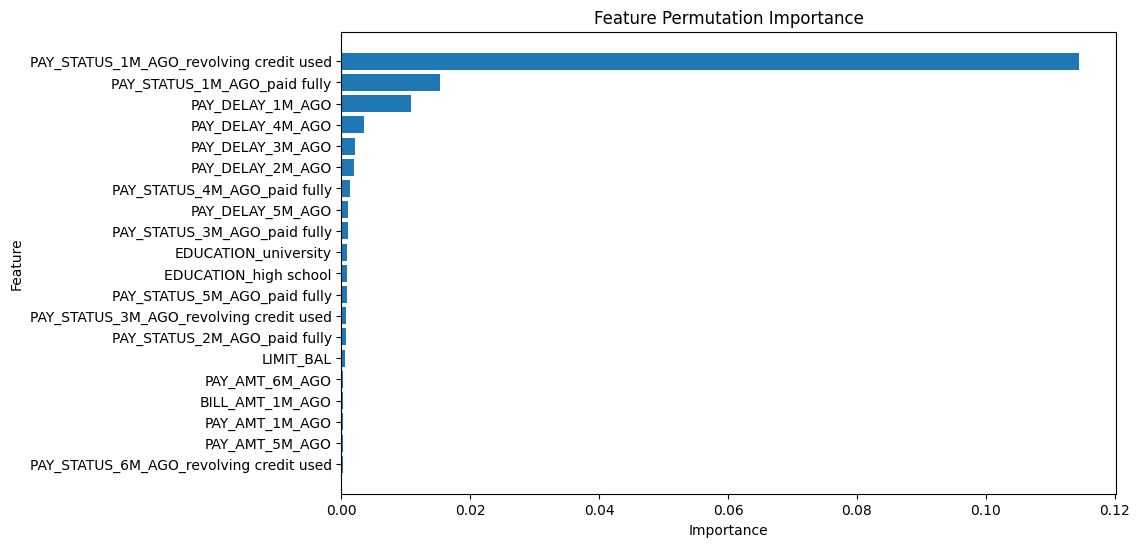

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related fe

In [ ]:
svm_perf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    708  4115   558  619      55.92   53.35        88.06     80.38     54.61   
1    991  1825  2848  336      25.81   74.68        39.05     46.93     38.37   
2    971  1864  2809  356      25.69   73.17        39.89     47.25     38.03   
3    948  1900  2773  379      25.48   71.44        40.66     47.47     37.56   
4    709  2117  2556  618      21.72   53.43        45.30     47.10     30.88   
5    542  2205  2468  785      18.01   40.84        47.19     45.78     24.99   
6    606  2059  2614  721      18.82   45.67        44.06     44.42     26.65   
7    567  2082  2591  760      17.95   42.73        44.55     44.15     25.28   
8   1286   319  4354   41      22.80   96.91         6.83     26.75     36.92   
9   1266   386  4287   61      22.80   95.40         8.26     27.53     36.80   
10  1311   114  4559   16      22.33   98.79         2.44     23.75     36.43   
11  1326    12  4661    1      22.15   99.92         0.26     22.30     36.26   
12  1327     5  4668    0      22.14  100.00         0.11     22.20     36.25   
13  1327     5  4668    0      22.14  100.00         0.11     22.20     36.25   
14  1327     5  4668    0      22.14  100.00         0.11     22.20     36.25   
15  1327     4  4669    0      22.13  100.00         0.09     22.18     36.24   
16  1327     4  4669    0      22.13  100.00         0.09     22.18     36.24   
17  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
18  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
19  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   
20  1327     1  4672    0      22.12  100.00         0.02     22.13     36.23   

    balanced_accuracy  num_feat_missing  \
0               70.71                 0   
1               56.87                 1   
2               56.53                 2   
3               56.05                 3   
4               49.37                 4   
5               44.01                 5   
6               44.86                 6   
7               43.64                 7   
8               51.87                 8   
9               51.83                 9   
10              50.62                10   
11              50.09                11   
12              50.05                12   
13              50.05                13   
14              50.05                14   
15              50.04                15   
16              50.04                16   
17              50.01                17   
18              50.01                18   
19              50.01                19   
20              50.01                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:51:08.111619

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  2
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUC

In [ ]:
svm_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   708  4115  558   619      55.92   53.35        88.06     80.38     54.61   
1   534  4239  434   793      55.17   40.24        90.71     79.55     46.54   
2   518  4246  427   809      54.81   39.04        90.86     79.40     45.60   
3   511  4256  417   816      55.06   38.51        91.08     79.45     45.32   
4   488  4335  338   839      59.08   36.77        92.77     80.38     45.33   
5   316  4432  241  1011      56.73   23.81        94.84     79.13     33.55   
6   310  4450  223  1017      58.16   23.36        95.23     79.33     33.33   
7   158  4544  129  1169      55.05   11.91        97.24     78.37     19.58   
8   140  4443  230  1187      37.84   10.55        95.08     76.38     16.50   
9   104  4525  148  1223      41.27    7.84        96.83     77.15     13.17   
10   53  4463  210  1274      20.15    3.99        95.51     75.27      6.67   
11   16  4672    1  1311      94.12    1.21        99.98     78.13      2.38   
12   14  4673    0  1313     100.00    1.06       100.00     78.12      2.09   
13   14  4673    0  1313     100.00    1.06       100.00     78.12      2.09   
14   13  4673    0  1314     100.00    0.98       100.00     78.10      1.94   
15   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
16   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
17   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
18   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
19   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
20   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   

    balanced_accuracy  num_feat_missing  \
0               70.71                 0   
1               65.48                 1   
2               64.95                 2   
3               64.79                 3   
4               64.77                 4   
5               59.33                 5   
6               59.29                 6   
7               54.57                 7   
8               52.81                 8   
9               52.34                 9   
10              49.75                10   
11              50.59                11   
12              50.53                12   
13              50.53                13   
14              50.49                14   
15              50.45                15   
16              50.45                16   
17              50.45                17   
18              50.45                18   
19              50.45                19   
20              50.45                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm_perf_temp, svm_orig_missing_temp, svm_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO    

In [ ]:
svm_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  708  4115  558   619      55.92   53.35        88.06     80.38     54.61   
1    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
2    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.71                 0   
1              50.00                 4   
2              50.00                 7   
3              50.00                10   
4              50.00                13   
5              50.00                16   
6              50.00                17   
7              50.00                18   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_temp_mf, svm_orig_missing_temp_mf, svm_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 18:58:09.951997

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']


In [ ]:
svm_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  708  4115  558   619      55.92   53.35        88.06     80.38     54.61   
1  519  4255  418   808      55.39   39.11        91.05     79.57     45.85   
2  520  4254  419   807      55.38   39.19        91.03     79.57     45.90   
3  451  4274  399   876      53.06   33.99        91.46     78.75     41.43   
4  249  4489  184  1078      57.51   18.76        96.06     78.97     28.30   
5    4  4671    2  1323      66.67    0.30        99.96     77.92      0.60   
6    7  4673    0  1320     100.00    0.53       100.00     78.00      1.05   
7    6  4673    0  1321     100.00    0.45       100.00     77.98      0.90   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.71                 0   
1              65.08                 4   
2              65.11                 7   
3              62.72                10   
4              57.41                13   
5              50.13                16   
6              50.26                17   
7              50.23                18   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**##

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicolinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_default_cc_dist_corr = default_cc_dist_corr[present_features]
filtered_default_cc_dist_corr = filtered_default_cc_dist_corr[filtered_default_cc_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_default_cc_dist_corr, 'Target', 0.8)

appended feature:  PAY_DELAY_1M_AGO
appended feature:  PAY_DELAY_2M_AGO
appended feature:  PAY_DELAY_3M_AGO
appended feature:  PAY_DELAY_4M_AGO
appended feature:  PAY_DELAY_5M_AGO
appended feature:  PAY_DELAY_6M_AGO
appended feature:  PAY_STATUS_1M_AGO_revolving credit used
appended feature:  LIMIT_BAL
appended feature:  PAY_AMT_2M_AGO
appended feature:  PAY_AMT_1M_AGO
appended feature:  PAY_STATUS_3M_AGO_revolving credit used
appended feature:  PAY_AMT_3M_AGO
appended feature:  PAY_STATUS_4M_AGO_revolving credit used
appended feature:  PAY_AMT_4M_AGO
appended feature:  PAY_AMT_5M_AGO
appended feature:  PAY_AMT_6M_AGO
appended feature:  PAY_STATUS_5M_AGO_revolving credit used
appended feature:  PAY_STATUS_6M_AGO_revolving credit used
appended feature:  PAY_STATUS_3M_AGO_paid fully
appended feature:  PAY_STATUS_2M_AGO_paid fully
appended feature:  PAY_STATUS_4M_AGO_paid fully
appended feature:  PAY_STATUS_5M_AGO_paid fully
appended feature:  PAY_STATUS_1M_AGO_paid fully
appended feature

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]
print('Nr features for LR: ', len(lr_X_train.columns))

Nr features for LR:  33


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [5.0],
      'penalty': ['l2'],
      'solver': ['liblinear']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 18:04:54.237885

Nested Cross-validation Results:
Individual scores: [0.53968254 0.52200772 0.52363636]
Average nested CV score: 0.528 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'penalty': 'l2', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.528
2025-01-18 18:04:56.772834

Execution time: 0.04 minutes


```
Starting hyperparameter tuning at: 2025-01-17 00:04:16.143004

Nested Cross-validation Results:
Individual scores: [0.53885481 0.52117769 0.52338877]
Average nested CV score: 0.528 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.528
2025-01-17 00:04:40.361862

Execution time: 0.40 minutes
```

In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.126976  0.004011
7                                 LIMIT_BAL    0.018956  0.000841
2                          PAY_DELAY_3M_AGO    0.011977  0.001153
28                          BILL_AMT_1M_AGO    0.008765  0.002077
22             PAY_STATUS_1M_AGO_paid fully    0.007695  0.000689
3                          PAY_DELAY_4M_AGO    0.005599  0.000979
19             PAY_STATUS_2M_AGO_paid fully    0.004909  0.000529
21             PAY_STATUS_5M_AGO_paid fully    0.002543  0.000214
10  PAY_STATUS_3M_AGO_revolving credit used    0.002407  0.000231
26                                 SEX_male    0.001984  0.001375
23             PAY_STATUS_6M_AGO_paid fully    0.001586  0.000407
24                         EDUCATION_others    0.001539  0.000960
29                          MARRIAGE_single    0.001474  0.001047
31                          BILL_AMT_6M_AGO    0.001165  0.000381
20             PAY_STATUS_4M_AGO_paid fully    0.001157  0.000669
5                          PAY_DELAY_6M_AGO    0.001127  0.000321
6   PAY_STATUS_1M_AGO_revolving credit used    0.001116  0.001567
14                           PAY_AMT_5M_AGO    0.001025  0.000422
27                    EDUCATION_high school    0.001002  0.000138
18             PAY_STATUS_3M_AGO_paid fully    0.000576  0.000188
11                           PAY_AMT_3M_AGO    0.000505  0.000359
4                          PAY_DELAY_5M_AGO    0.000437  0.000211
9                            PAY_AMT_1M_AGO    0.000432  0.000888
32                          MARRIAGE_others    0.000413  0.000285
15                           PAY_AMT_6M_AGO    0.000336  0.000852
17  PAY_STATUS_6M_AGO_revolving credit used    0.000273  0.001472
30                                      AGE    0.000252  0.000376
8                            PAY_AMT_2M_AGO    0.000090  0.000661
25                     EDUCATION_university    0.000080  0.000256
13                           PAY_AMT_4M_AGO   -0.000114  0.000267
1                          PAY_DELAY_2M_AGO   -0.000356  0.000317
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000936  0.000603
16  PAY_STATUS_5M_AGO_revolving credit used   -0.001562  0.000896

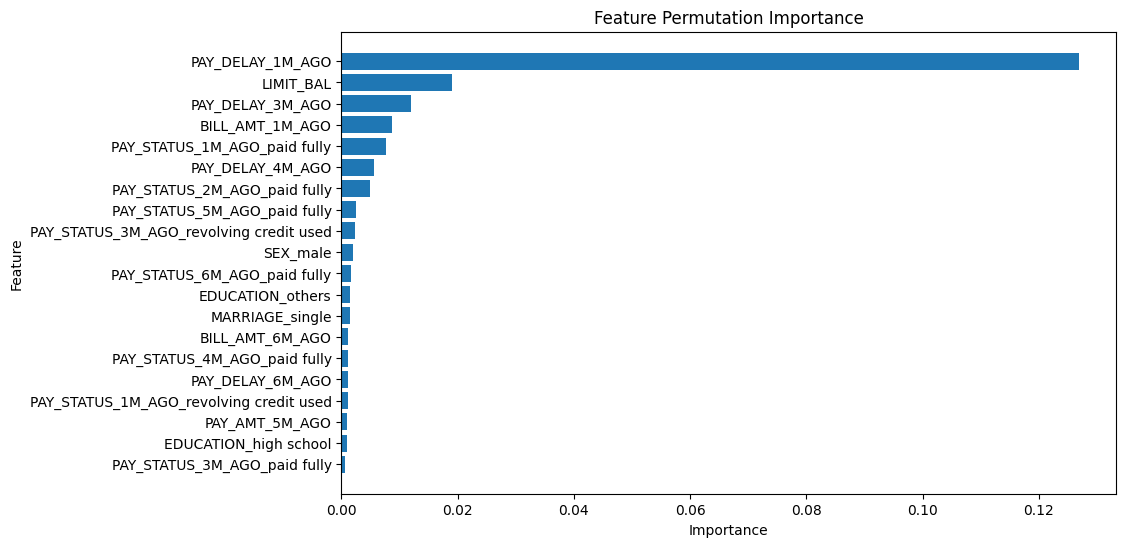

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO', 'PA

In [ ]:
lr_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879  794   520      50.41   60.81        83.01     78.10     55.12   
1   482  4257  416   845      53.67   36.32        91.10     78.98     43.33   
2   444  4288  385   883      53.56   33.46        91.76     78.87     41.19   
3   332  4383  290   995      53.38   25.02        93.79     78.58     34.07   
4   306  4388  285  1021      51.78   23.06        93.90     78.23     31.91   
5   283  4450  223  1044      55.93   21.33        95.23     78.88     30.88   
6   176  4515  158  1151      52.69   13.26        96.62     78.18     21.19   
7   179  4503  170  1148      51.29   13.49        96.36     78.03     21.36   
8    82  4619   54  1245      60.29    6.18        98.84     78.35     11.21   
9   101  4597   76  1226      57.06    7.61        98.37     78.30     13.43   
10   45  4645   28  1282      61.64    3.39        99.40     78.17      6.43   
11   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
12   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
13   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
14   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
15    4  4673    0  1323     100.00    0.30       100.00     77.95      0.60   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.91                 0   
1               63.71                 1   
2               62.61                 2   
3               59.41                 3   
4               58.48                 4   
5               58.28                 5   
6               54.94                 6   
7               54.93                 7   
8               52.51                 8   
9               52.99                 9   
10              51.40                10   
11              50.45                11   
12              50.45                12   
13              50.45                13   
14              50.45                14   
15              50.15                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr_X_train.columns

Index(['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO',
       'PAY_STATUS_1M_AGO_revolving credit used', 'LIMIT_BAL',
       'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO',
       'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_AMT_3M_AGO',
       'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_AMT_4M_AGO',
       'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_STATUS_5M_AGO_revolving credit used',
       'PAY_STATUS_6M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully',
       'EDUCATION_others', 'EDUCATION_university', 'SEX_male',
       'EDUCATION_high school', 'BILL_AMT_1M_AGO', 'MARRIAGE_single', 'AGE',
       'BILL_AMT_6M_AGO', 'MARRIAGE_others'],
      dtype='object')

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_default_cc_cat_vars = [col for col in lr_X_train.columns if col in default_cc_cat_vars]

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:00:37.333200

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879  794  520      50.41   60.81        83.01     78.10     55.12   
1   758  3811  862  569      46.79   57.12        81.55     76.15     51.44   
2   748  3862  811  579      47.98   56.37        82.64     76.83     51.84   
3   742  3846  827  585      47.29   55.92        82.30     76.47     51.24   
4   710  3949  724  617      49.51   53.50        84.51     77.65     51.43   
5   681  4001  672  646      50.33   51.32        85.62     78.03     50.82   
6   667  4045  628  660      51.51   50.26        86.56     78.53     50.88   
7   645  4093  580  682      52.65   48.61        87.59     78.97     50.55   
8   639  4107  566  688      53.03   48.15        87.89     79.10     50.47   
9   604  4220  453  723      57.14   45.52        90.31     80.40     50.67   
10  585  4244  429  742      57.69   44.08        90.82     80.48     49.98   
11  558  4307  366  769      60.39   42.05        92.17     81.08     49.58   
12  565  4298  375  762      60.11   42.58        91.98     81.05     49.85   
13  570  4291  382  757      59.87   42.95        91.83     81.02     50.02   
14  564  4295  378  763      59.87   42.50        91.91     80.98     49.71   
15  568  4294  379  759      59.98   42.80        91.89     81.03     49.96   
16  539  4341  332  788      61.88   40.62        92.90     81.33     49.04   
17  535  4340  333  792      61.64   40.32        92.87     81.25     48.75   
18  541  4331  342  786      61.27   40.77        92.68     81.20     48.96   
19  530  4339  334  797      61.34   39.94        92.85     81.15     48.38   
20  548  4313  360  779      60.35   41.30        92.30     81.02     49.04   

    balanced_accuracy  num_feat_missing  \
0               71.91                 0   
1               69.34                 1   
2               69.51                 2   
3               69.11                 3   
4               69.01                 4   
5               68.47                 5   
6               68.41                 6   
7               68.10                 7   
8               68.02                 8   
9               67.91                 9   
10              67.45                10   
11              67.11                11   
12              67.28                12   
13              67.39                13   
14              67.21                14   
15              67.35                15   
16              66.76                16   
17              66.60                17   
18              66.73                18   
19              66.40                19   
20              66.80                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr_perf_temp, lr_orig_missing_temp, lr_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879   794   520      50.41   60.81        83.01     78.10     55.12   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.91                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                11   
5              50.00                14   
6              50.00                17   
7              50.00                18   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_temp_mf, lr_orig_missing_temp_mf, lr_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:05:21.310604

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  807  3879  794   520      50.41   60.81        83.01     78.10     55.12   
1  692  3928  745   635      48.16   52.15        84.06     77.00     50.07   
2  706  3906  767   621      47.93   53.20        83.59     76.87     50.43   
3  642  4119  554   685      53.68   48.38        88.14     79.35     50.89   
4  643  4109  564   684      53.27   48.46        87.93     79.20     50.75   
5  345  4393  280   982      55.20   26.00        94.01     78.97     35.35   
6  148  4574   99  1179      59.92   11.15        97.88     78.70     18.81   
7  121  4600   73  1206      62.37    9.12        98.44     78.68     15.91   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.91                 0   
1              68.10                 4   
2              68.39                 5   
3              68.26                 8   
4              68.19                11   
5              60.00                14   
6              54.52                17   
7              53.78                18   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Models optimized for Balanced Accuracy**

## **Decision Tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [None],
      'min_samples_split': [0.05],
      'min_samples_leaf': [0.01]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:07:10.505790

Nested Cross-validation Results:
Individual scores: [0.70843611 0.69479283 0.69444913]
Average nested CV score: 0.699 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.699
2025-01-18 19:07:14.005450

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 04:54:16.438437

Nested Cross-validation Results:
Individual scores: [0.70843611 0.69289115 0.69410362]
Average nested CV score: 0.698 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.699
2025-01-17 04:54:58.319696

Execution time: 0.70 minutes
```

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0               PAY_DELAY_1M_AGO    0.079540  0.002291
3               PAY_DELAY_4M_AGO    0.021853  0.000894
2               PAY_DELAY_3M_AGO    0.011828  0.000849
20  PAY_STATUS_4M_AGO_paid fully    0.009881  0.001508
9                 PAY_AMT_1M_AGO    0.007415  0.000878
8                 PAY_AMT_2M_AGO    0.006418  0.000863
28               BILL_AMT_1M_AGO    0.004799  0.000688
11                PAY_AMT_3M_AGO    0.004157  0.000888
13                PAY_AMT_4M_AGO    0.003803  0.000732
7                      LIMIT_BAL    0.003733  0.000509

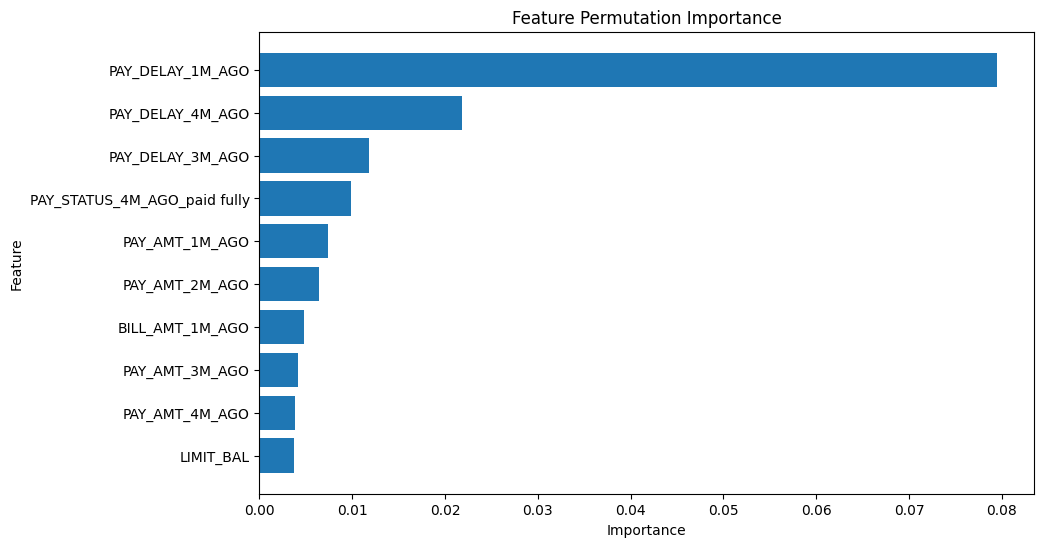

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_paid fully
Removing related features:  ['PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'P

In [ ]:
dt2_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   911  3470  1203   416      43.09   68.65        74.26     73.02     52.95   
1   729  3633  1040   598      41.21   54.94        77.74     72.70     47.09   
2   509  3841   832   818      37.96   38.36        82.20     72.50     38.16   
3   278  4069   604  1049      31.52   20.95        87.07     72.45     25.17   
4   278  4069   604  1049      31.52   20.95        87.07     72.45     25.17   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.45                 0   
1               66.34                 1   
2               60.28                 2   
3               54.01                 3   
4               54.01                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:07:15.917303

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
dt2_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   911  3470  1203  416      43.09   68.65        74.26     73.02     52.95   
1   813  3512  1161  514      41.19   61.27        75.16     72.08     49.26   
2   785  3580  1093  542      41.80   59.16        76.61     72.75     48.99   
3   729  3712   961  598      43.14   54.94        79.44     74.02     48.33   
4   745  3698   975  582      43.31   56.14        79.14     74.05     48.90   
5   679  3962   711  648      48.85   51.17        84.78     77.35     49.98   
6   618  4156   517  709      54.45   46.57        88.94     79.57     50.20   
7   569  4271   402  758      58.60   42.88        91.40     80.67     49.52   
8   566  4270   403  761      58.41   42.65        91.38     80.60     49.30   
9   578  4260   413  749      58.32   43.56        91.16     80.63     49.87   
10  578  4265   408  749      58.62   43.56        91.27     80.72     49.98   
11  580  4260   413  747      58.41   43.71        91.16     80.67     50.00   
12  581  4259   414  746      58.39   43.78        91.14     80.67     50.04   
13  595  4241   432  732      57.94   44.84        90.76     80.60     50.55   
14  598  4234   439  729      57.67   45.06        90.61     80.53     50.59   
15  598  4234   439  729      57.67   45.06        90.61     80.53     50.59   
16  598  4234   439  729      57.67   45.06        90.61     80.53     50.59   
17  598  4234   439  729      57.67   45.06        90.61     80.53     50.59   
18  598  4234   439  729      57.67   45.06        90.61     80.53     50.59   
19  593  4245   428  734      58.08   44.69        90.84     80.63     50.51   
20  592  4249   424  735      58.27   44.61        90.93     80.68     50.53   

    balanced_accuracy  num_feat_missing  \
0               71.45                 0   
1               68.21                 1   
2               67.88                 2   
3               67.19                 3   
4               67.64                 4   
5               67.98                 5   
6               67.75                 6   
7               67.14                 7   
8               67.01                 8   
9               67.36                 9   
10              67.41                10   
11              67.43                11   
12              67.46                12   
13              67.80                13   
14              67.83                14   
15              67.83                15   
16              67.83                16   
17              67.83                17   
18              67.83                18   
19              67.76                19   
20              67.77                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_...

In [ ]:
dt2_perf_temp, dt2_orig_missing_temp, dt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
dt2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  911  3470  1203   416      43.09   68.65        74.26     73.02     52.95   
1  527  4186   487   800      51.97   39.71        89.58     78.55     45.02   
2  307  4394   279  1020      52.39   23.13        94.03     78.35     32.10   
3    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.45                 0   
1              64.65                 4   
2              58.58                 7   
3              50.00                10   
4              50.00                13   
5              50.00                14   
6              50.00                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_temp_mf, dt2_orig_missing_temp_mf, dt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:11:55.454158

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
dt2_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  911  3470  1203   416      43.09   68.65        74.26     73.02     52.95   
1  657  4032   641   670      50.62   49.51        86.28     78.15     50.06   
2  648  4071   602   679      51.84   48.83        87.12     78.65     50.29   
3  593  4244   429   734      58.02   44.69        90.82     80.62     50.49   
4  257  4521   152  1070      62.84   19.37        96.75     79.63     29.61   
5  255  4523   150  1072      62.96   19.22        96.79     79.63     29.45   
6   35  4652    21  1292      62.50    2.64        99.55     78.12      5.06   
7    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.45                 0   
1              67.90                 4   
2              67.97                 7   
3              67.75                10   
4              58.06                13   
5              58.00                14   
6              51.09                18   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [200],
    'max_features': ['sqrt'],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.001],
    'max_depth': [None]
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:13:42.930071

Nested Cross-validation Results:
Individual scores: [0.71932062 0.70741265 0.71268012]
Average nested CV score: 0.713 (+/- 0.010)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.713
2025-01-18 19:14:03.997028

Execution time: 0.35 minutes


```
Starting hyperparameter tuning at: 2025-01-17 04:54:59.198610

Nested Cross-validation Results:
Individual scores: [0.7213733  0.70348324 0.71173291]
Average nested CV score: 0.712 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.713
2025-01-17 06:13:04.884949

Execution time: 78.09 minutes

```

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.050502  0.001945
11                           PAY_AMT_3M_AGO    0.010962  0.000884
9                            PAY_AMT_1M_AGO    0.010532  0.001358
28                          BILL_AMT_1M_AGO    0.010467  0.000532
13                           PAY_AMT_4M_AGO    0.008867  0.000633
7                                 LIMIT_BAL    0.007837  0.001074
8                            PAY_AMT_2M_AGO    0.005418  0.000842
14                           PAY_AMT_5M_AGO    0.004241  0.000261
6   PAY_STATUS_1M_AGO_revolving credit used    0.003599  0.000713
15                           PAY_AMT_6M_AGO    0.003558  0.000423
31                          BILL_AMT_6M_AGO    0.003502  0.000624
2                          PAY_DELAY_3M_AGO    0.003109  0.000500
1                          PAY_DELAY_2M_AGO    0.003099  0.001481
30                                      AGE    0.002420  0.000508
22             PAY_STATUS_1M_AGO_paid fully    0.001922  0.000288
18             PAY_STATUS_3M_AGO_paid fully    0.001665  0.000329
3                          PAY_DELAY_4M_AGO    0.001637  0.000372
19             PAY_STATUS_2M_AGO_paid fully    0.000943  0.000296
17  PAY_STATUS_6M_AGO_revolving credit used    0.000826  0.000289
25                     EDUCATION_university    0.000577  0.000203
29                          MARRIAGE_single    0.000499  0.000150
10  PAY_STATUS_3M_AGO_revolving credit used    0.000433  0.000267
23             PAY_STATUS_6M_AGO_paid fully    0.000416  0.000420
24                         EDUCATION_others    0.000362  0.000129
26                                 SEX_male    0.000325  0.000171
16  PAY_STATUS_5M_AGO_revolving credit used    0.000275  0.000198
27                    EDUCATION_high school    0.000210  0.000162
20             PAY_STATUS_4M_AGO_paid fully    0.000057  0.000096
21             PAY_STATUS_5M_AGO_paid fully    0.000045  0.000169
4                          PAY_DELAY_5M_AGO   -0.000069  0.000425
5                          PAY_DELAY_6M_AGO   -0.000228  0.000262
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000346  0.000230

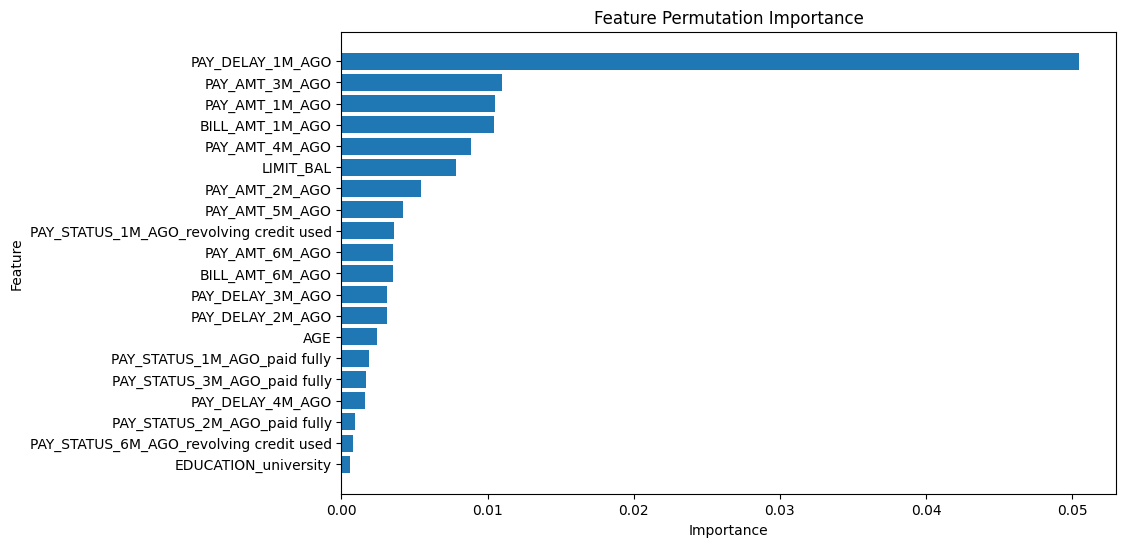

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed s

In [ ]:
rf2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   840  3839  834   487      50.18   63.30        82.15     77.98     55.98   
1   726  3971  702   601      50.84   54.71        84.98     78.28     52.70   
2   650  4160  513   677      55.89   48.98        89.02     80.17     52.21   
3   618  4200  473   709      56.65   46.57        89.88     80.30     51.12   
4   590  4235  438   737      57.39   44.46        90.63     80.42     50.11   
5   586  4231  442   741      57.00   44.16        90.54     80.28     49.77   
6   518  4330  343   809      60.16   39.04        92.66     80.80     47.35   
7   513  4341  332   814      60.71   38.66        92.90     80.90     47.24   
8   510  4343  330   817      60.71   38.43        92.94     80.88     47.07   
9   519  4315  358   808      59.18   39.11        92.34     80.57     47.10   
10  519  4311  362   808      58.91   39.11        92.25     80.50     47.01   
11  520  4312  361   807      59.02   39.19        92.27     80.53     47.10   
12  424  4397  276   903      60.57   31.95        94.09     80.35     41.84   
13  313  4471  202  1014      60.78   23.59        95.68     79.73     33.98   
14  313  4471  202  1014      60.78   23.59        95.68     79.73     33.98   
15  316  4468  205  1011      60.65   23.81        95.61     79.73     34.20   
16  175  4552  121  1152      59.12   13.19        97.41     78.78     21.57   
17  175  4552  121  1152      59.12   13.19        97.41     78.78     21.57   
18  242  4537  136  1085      64.02   18.24        97.09     79.65     28.39   
19  236  4544  129  1091      64.66   17.78        97.24     79.67     27.90   
20  236  4544  129  1091      64.66   17.78        97.24     79.67     27.90   

    balanced_accuracy  num_feat_missing  \
0               72.73                 0   
1               69.84                 1   
2               69.00                 2   
3               68.22                 3   
4               67.54                 4   
5               67.35                 5   
6               65.85                 6   
7               65.78                 7   
8               65.69                 8   
9               65.72                 9   
10              65.68                10   
11              65.73                11   
12              63.02                12   
13              59.63                13   
14              59.63                14   
15              59.71                15   
16              55.30                16   
17              55.30                17   
18              57.66                18   
19              57.51                19   
20              57.51                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2      ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
4   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
5   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
6   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
7   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
8   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
9   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
10  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
11  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
12  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
13  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
14  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
15  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
16  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
17  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
18  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
19  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
20  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:14:24.313296

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
rf2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   840  3839  834   487      50.18   63.30        82.15     77.98     55.98   
1   756  3886  787   571      49.00   56.97        83.16     77.37     52.68   
2   732  3970  703   595      51.01   55.16        84.96     78.37     53.01   
3   674  4083  590   653      53.32   50.79        87.37     79.28     52.03   
4   647  4135  538   680      54.60   48.76        88.49     79.70     51.51   
5   639  4157  516   688      55.32   48.15        88.96     79.93     51.49   
6   633  4160  513   694      55.24   47.70        89.02     79.88     51.19   
7   630  4176  497   697      55.90   47.48        89.36     80.10     51.34   
8   623  4194  479   704      56.53   46.95        89.75     80.28     51.30   
9   608  4210  463   719      56.77   45.82        90.09     80.30     50.71   
10  607  4202  471   720      56.31   45.74        89.92     80.15     50.48   
11  635  4133  540   692      54.04   47.85        88.44     79.47     50.76   
12  610  4224  449   717      57.60   45.97        90.39     80.57     51.13   
13  316  4471  202  1011      61.00   23.81        95.68     79.78     34.25   
14  318  4474  199  1009      61.51   23.96        95.74     79.87     34.49   
15  313  4479  194  1014      61.74   23.59        95.85     79.87     34.13   
16  268  4514  159  1059      62.76   20.20        96.60     79.70     30.56   
17  268  4514  159  1059      62.76   20.20        96.60     79.70     30.56   
18  268  4514  159  1059      62.76   20.20        96.60     79.70     30.56   
19  268  4514  159  1059      62.76   20.20        96.60     79.70     30.56   
20  268  4514  159  1059      62.76   20.20        96.60     79.70     30.56   

    balanced_accuracy  num_feat_missing  \
0               72.73                 0   
1               70.06                 1   
2               70.06                 2   
3               69.08                 3   
4               68.62                 4   
5               68.56                 5   
6               68.36                 6   
7               68.42                 7   
8               68.35                 8   
9               67.95                 9   
10              67.83                10   
11              68.15                11   
12              68.18                12   
13              59.75                13   
14              59.85                14   
15              59.72                15   
16              58.40                16   
17              58.40                17   
18              58.40                18   
19              58.40                19   
20              58.40                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2      ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
4   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
5   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
6   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
7   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
8   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
9   ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
10  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
11  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
12  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
13  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
14  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
15  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
16  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
17  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
18  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
19  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...  
20  ['PAY_DELAY_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AM...

In [ ]:
rf2_perf_temp, rf2_orig_missing_temp, rf2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
rf2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  840  3839  834   487      50.18   63.30        82.15     77.98     55.98   
1  618  4132  541   709      53.32   46.57        88.42     79.17     49.72   
2  557  4243  430   770      56.43   41.97        90.80     80.00     48.14   
3  511  4306  367   816      58.20   38.51        92.15     80.28     46.35   
4  382  4440  233   945      62.11   28.79        95.01     80.37     39.34   
5  257  4523  150  1070      63.14   19.37        96.79     79.67     29.64   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.73                 0   
1              67.50                 4   
2              66.39                 7   
3              65.33                10   
4              61.90                11   
5              58.08                14   
6              50.00                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_temp_mf, rf2_orig_missing_temp_mf, rf2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:19:13.793739

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
rf2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  840  3839  834   487      50.18   63.30        82.15     77.98     55.98   
1  630  4134  539   697      53.89   47.48        88.47     79.40     50.48   
2  604  4226  447   723      57.47   45.52        90.43     80.50     50.80   
3  569  4287  386   758      59.58   42.88        91.74     80.93     49.87   
4  575  4271  402   752      58.85   43.33        91.40     80.77     49.91   
5  270  4509  164  1057      62.21   20.35        96.49     79.65     30.66   
6    4  4673    0  1323     100.00    0.30       100.00     77.95      0.60   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.73                 0   
1              67.97                 4   
2              67.98                 7   
3              67.31                10   
4              67.36                11   
5              58.42                14   
6              50.15                17   
7              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Gradient -Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [1],
      'min_split_gain': [1.0],
      'reg_lambda': [5.0]
  }

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:20:53.471009

Nested Cross-validation Results:
Individual scores: [0.72099717 0.71095574 0.70560437]
Average nested CV score: 0.713 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 1, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.713
2025-01-18 19:20:58.337421

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-17 07:01:34.310535

Nested Cross-validation Results:
Individual scores: [0.71966777 0.70680505 0.70436198]
Average nested CV score: 0.710 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 1, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.713
2025-01-17 07:11:04.575436

Execution time: 9.50 minutes
```

In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.070188  0.001608
28                          BILL_AMT_1M_AGO    0.008353  0.000879
7                                 LIMIT_BAL    0.008211  0.001667
2                          PAY_DELAY_3M_AGO    0.006847  0.000683
11                           PAY_AMT_3M_AGO    0.006097  0.000680
8                            PAY_AMT_2M_AGO    0.005349  0.000867
13                           PAY_AMT_4M_AGO    0.004565  0.001211
9                            PAY_AMT_1M_AGO    0.003793  0.000408
24                         EDUCATION_others    0.002982  0.000504
3                          PAY_DELAY_4M_AGO    0.002478  0.000634
22             PAY_STATUS_1M_AGO_paid fully    0.002388  0.000391
1                          PAY_DELAY_2M_AGO    0.001816  0.000942
15                           PAY_AMT_6M_AGO    0.001710  0.000472
31                          BILL_AMT_6M_AGO    0.001708  0.000400
30                                      AGE    0.001145  0.000119
5                          PAY_DELAY_6M_AGO    0.001131  0.000113
29                          MARRIAGE_single    0.000626  0.000524
26                                 SEX_male    0.000461  0.000395
32                          MARRIAGE_others    0.000459  0.000142
14                           PAY_AMT_5M_AGO    0.000435  0.000095
20             PAY_STATUS_4M_AGO_paid fully    0.000394  0.000217
6   PAY_STATUS_1M_AGO_revolving credit used    0.000389  0.000265
4                          PAY_DELAY_5M_AGO    0.000256  0.000557
17  PAY_STATUS_6M_AGO_revolving credit used    0.000205  0.000113
18             PAY_STATUS_3M_AGO_paid fully    0.000199  0.000117
25                     EDUCATION_university    0.000072  0.000230
21             PAY_STATUS_5M_AGO_paid fully   -0.000152  0.000189

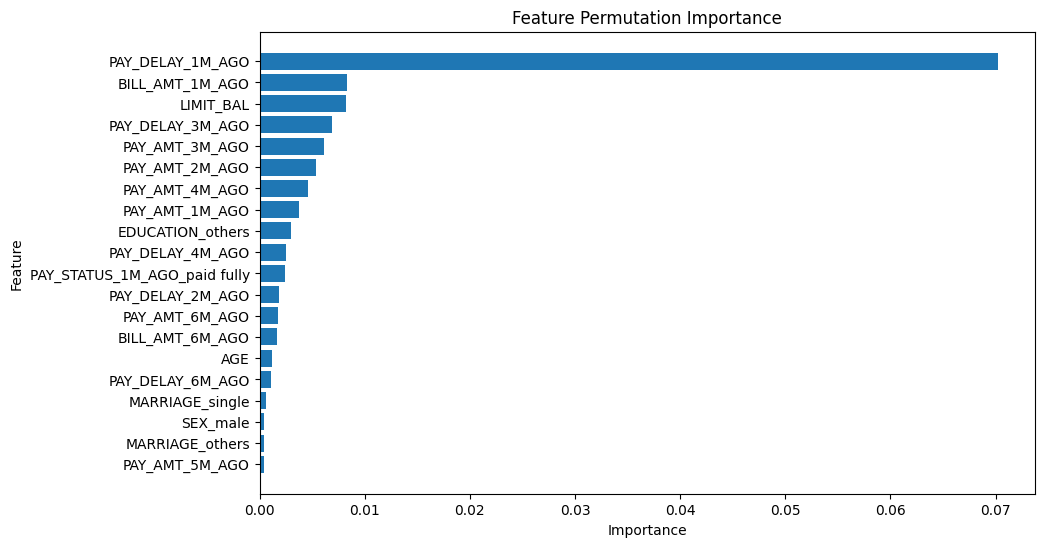

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far

In [ ]:
gbt2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   868  3732  941   459      47.98   65.41        79.86     76.67     55.36   
1   671  3937  736   656      47.69   50.57        84.25     76.80     49.09   
2   505  4263  410   822      55.19   38.06        91.23     79.47     45.05   
3   433  4392  281   894      60.64   32.63        93.99     80.42     42.43   
4   295  4506  167  1032      63.85   22.23        96.43     80.02     32.98   
5   272  4534  139  1055      66.18   20.50        97.03     80.10     31.30   
6   286  4516  157  1041      64.56   21.55        96.64     80.03     32.32   
7   283  4515  158  1044      64.17   21.33        96.62     79.97     32.01   
8   247  4539  134  1080      64.83   18.61        97.13     79.77     28.92   
9   245  4541  132  1082      64.99   18.46        97.18     79.77     28.76   
10   32  4663   10  1295      76.19    2.41        99.79     78.25      4.67   
11   32  4666    7  1295      82.05    2.41        99.85     78.30      4.69   
12    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.64                 0   
1               67.41                 1   
2               64.64                 2   
3               63.31                 3   
4               59.33                 4   
5               58.76                 5   
6               59.10                 6   
7               58.97                 7   
8               57.87                 8   
9               57.82                 9   
10              51.10                10   
11              51.13                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:21:02.716296

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
gbt2_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    868  3732   941  459      47.98   65.41        79.86     76.67     55.36   
1   1098  2224  2449  229      30.96   82.74        47.59     55.37     45.06   
2   1034  2528  2145  293      32.53   77.92        54.10     59.37     45.89   
3    993  2659  2014  334      33.02   74.83        56.90     60.87     45.82   
4   1142  1680  2993  185      27.62   86.06        35.95     47.03     41.82   
5   1145  1752  2921  182      28.16   86.28        37.49     48.28     42.46   
6   1062  2393  2280  265      31.78   80.03        51.21     57.58     45.49   
7    991  2616  2057  336      32.51   74.68        55.98     60.12     45.30   
8   1001  2589  2084  326      32.45   75.43        55.40     59.83     45.38   
9   1009  2518  2155  318      31.89   76.04        53.88     58.78     44.93   
10  1113  1872  2801  214      28.44   83.87        40.06     49.75     42.47   
11  1115  1851  2822  212      28.32   84.02        39.61     49.43     42.36   
12  1021  1929  2744  306      27.12   76.94        41.28     49.17     40.10   
13  1014  1763  2910  313      25.84   76.41        37.73     46.28     38.62   
14  1239   514  4159   88      22.95   93.37        11.00     29.22     36.85   
15  1302   239  4434   25      22.70   98.12         5.11     25.68     36.87   
16  1325    47  4626    2      22.27   99.85         1.01     22.87     36.41   
17  1325    38  4635    2      22.23   99.85         0.81     22.72     36.37   
18  1324    42  4631    3      22.23   99.77         0.90     22.77     36.36   
19  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
20  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

    balanced_accuracy  num_feat_missing  \
0               72.64                 0   
1               65.17                 1   
2               66.01                 2   
3               65.87                 3   
4               61.00                 4   
5               61.89                 5   
6               65.62                 6   
7               65.33                 7   
8               65.42                 8   
9               64.96                 9   
10              61.97                10   
11              61.82                11   
12              59.11                12   
13              57.07                13   
14              52.18                14   
15              51.62                15   
16              50.43                16   
17              50.33                17   
18              50.34                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
gbt2_perf_temp, gbt2_orig_missing_temp, gbt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
gbt2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  868  3732  941   459      47.98   65.41        79.86     76.67     55.36   
1  468  4317  356   859      56.80   35.27        92.38     79.75     43.51   
2  410  4413  260   917      61.19   30.90        94.44     80.38     41.06   
3  227  4552  121  1100      65.23   17.11        97.41     79.65     27.10   
4  220  4548  125  1107      63.77   16.58        97.33     79.47     26.32   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.64                 0   
1              63.82                 4   
2              62.67                 5   
3              57.26                 8   
4              56.95                11   
5              50.00                14   
6              50.00                15   
7              50.00                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_temp_mf, gbt2_orig_missing_temp_mf, gbt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:25:43.548115

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
gbt2_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   868  3732   941  459      47.98   65.41        79.86     76.67     55.36   
1   910  3081  1592  417      36.37   68.58        65.93     66.52     47.53   
2   905  3101  1572  422      36.54   68.20        66.36     66.77     47.58   
3  1102  1992  2681  225      29.13   83.04        42.63     51.57     43.13   
4   925  2617  2056  402      31.03   69.71        56.00     59.03     42.94   
5  1036  1780  2893  291      26.37   78.07        38.09     46.93     39.42   
6  1053  1650  3023  274      25.83   79.35        35.31     45.05     38.98   
7  1316    56  4617   11      22.18   99.17         1.20     22.87     36.25   
8  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              72.64                 0   
1              67.25                 4   
2              67.28                 5   
3              62.84                 8   
4              62.85                11   
5              58.08                14   
6              57.33                15   
7              50.18                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[0.5],
    'gamma': [0.1],
    'colsample_bytree':[0.5]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:27:36.492188

Nested Cross-validation Results:
Individual scores: [0.72653867 0.70524163 0.70879198]
Average nested CV score: 0.714 (+/- 0.019)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.714
2025-01-18 19:27:40.946470

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-17 07:11:04.594900

Nested Cross-validation Results:
Individual scores: [0.72111933 0.70560755 0.7066926 ]
Average nested CV score: 0.711 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.714
2025-01-17 07:30:30.308672

Execution time: 19.43 minutes
```

In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.058799  0.002146
28                          BILL_AMT_1M_AGO    0.015862  0.001238
7                                 LIMIT_BAL    0.007945  0.001343
11                           PAY_AMT_3M_AGO    0.007033  0.001179
2                          PAY_DELAY_3M_AGO    0.005096  0.000410
8                            PAY_AMT_2M_AGO    0.004664  0.000890
24                         EDUCATION_others    0.003915  0.000948
9                            PAY_AMT_1M_AGO    0.003384  0.001068
1                          PAY_DELAY_2M_AGO    0.002687  0.000561
3                          PAY_DELAY_4M_AGO    0.002402  0.000633
13                           PAY_AMT_4M_AGO    0.002360  0.000917
14                           PAY_AMT_5M_AGO    0.001520  0.000623
22             PAY_STATUS_1M_AGO_paid fully    0.001192  0.000905
31                          BILL_AMT_6M_AGO    0.001160  0.000791
4                          PAY_DELAY_5M_AGO    0.001058  0.000523
15                           PAY_AMT_6M_AGO    0.000692  0.001047
32                          MARRIAGE_others    0.000430  0.000141
29                          MARRIAGE_single    0.000414  0.000246
19             PAY_STATUS_2M_AGO_paid fully    0.000397  0.000099
25                     EDUCATION_university    0.000370  0.000430
30                                      AGE    0.000311  0.000418
23             PAY_STATUS_6M_AGO_paid fully    0.000295  0.000337
10  PAY_STATUS_3M_AGO_revolving credit used    0.000289  0.000143
21             PAY_STATUS_5M_AGO_paid fully    0.000228  0.000130
5                          PAY_DELAY_6M_AGO    0.000206  0.000457
6   PAY_STATUS_1M_AGO_revolving credit used   -0.000060  0.000371
18             PAY_STATUS_3M_AGO_paid fully   -0.000069  0.000330
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000194  0.000298
26                                 SEX_male   -0.000245  0.000331

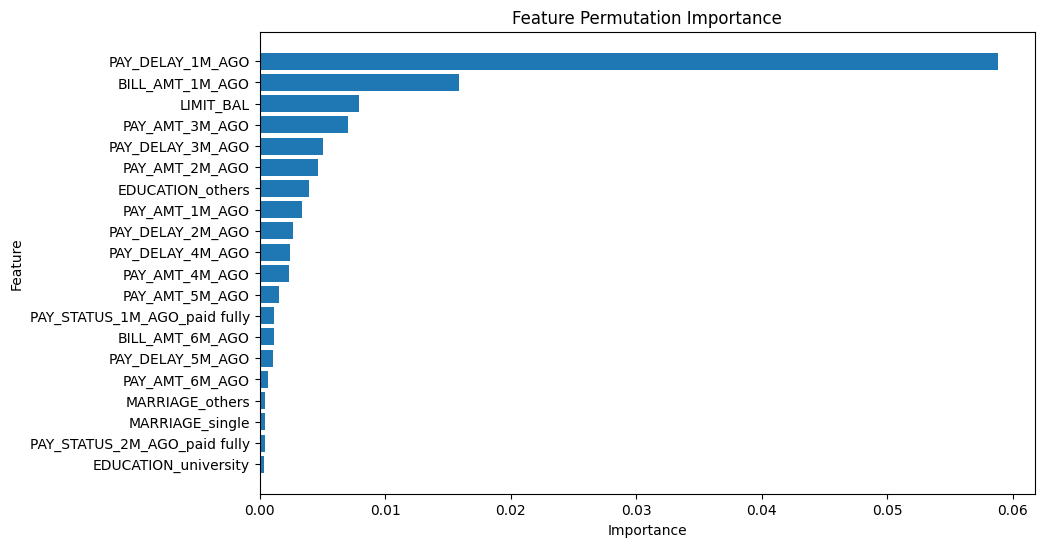

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT_BAL', 'PAY_AMT_3M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  EDUCATION_others
Removing related features:  

In [ ]:
xgb2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   864  3736  937   463      47.97   65.11        79.95     76.67     55.24   
1   697  3929  744   630      48.37   52.52        84.08     77.10     50.36   
2   546  4279  394   781      58.09   41.15        91.57     80.42     48.17   
3   494  4356  317   833      60.91   37.23        93.22     80.83     46.21   
4   451  4417  256   876      63.79   33.99        94.52     81.13     44.35   
5   302  4521  152  1025      66.52   22.76        96.75     80.38     33.91   
6   293  4531  142  1034      67.36   22.08        96.96     80.40     33.26   
7   293  4536  137  1034      68.14   22.08        97.07     80.48     33.35   
8   282  4539  134  1045      67.79   21.25        97.13     80.35     32.36   
9   241  4548  125  1086      65.85   18.16        97.33     79.82     28.47   
10   36  4646   27  1291      57.14    2.71        99.42     78.03      5.18   
11   51  4643   30  1276      62.96    3.84        99.36     78.23      7.24   
12   36  4656   17  1291      67.92    2.71        99.64     78.20      5.22   
13   34  4654   19  1293      64.15    2.56        99.59     78.13      4.93   
14   27  4662   11  1300      71.05    2.03        99.76     78.15      3.96   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.53                 0   
1               68.30                 1   
2               66.36                 2   
3               65.22                 3   
4               64.25                 4   
5               59.75                 5   
6               59.52                 6   
7               59.57                 7   
8               59.19                 8   
9               57.74                 9   
10              51.07                10   
11              51.60                11   
12              51.17                12   
13              51.08                13   
14              50.90                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())


xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:27:44.233256

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
xgb2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   864  3736  937   463      47.97   65.11        79.95     76.67     55.24   
1   748  3871  802   579      48.26   56.37        82.84     76.98     52.00   
2   673  4028  645   654      51.06   50.72        86.20     78.35     50.89   
3   653  4087  586   674      52.70   49.21        87.46     79.00     50.90   
4   592  4221  452   735      56.70   44.61        90.33     80.22     49.94   
5   567  4263  410   760      58.03   42.73        91.23     80.50     49.22   
6   539  4325  348   788      60.77   40.62        92.55     81.07     48.69   
7   541  4320  353   786      60.51   40.77        92.45     81.02     48.72   
8   546  4309  364   781      60.00   41.15        92.21     80.92     48.82   
9   259  4530  143  1068      64.43   19.52        96.94     79.82     29.96   
10  117  4607   66  1210      63.93    8.82        98.59     78.73     15.50   
11  103  4620   53  1224      66.03    7.76        98.87     78.72     13.89   
12   79  4634   39  1248      66.95    5.95        99.17     78.55     10.93   
13   78  4634   39  1249      66.67    5.88        99.17     78.53     10.80   
14   72  4630   43  1255      62.61    5.43        99.08     78.37      9.99   
15   10  4673    0  1317     100.00    0.75       100.00     78.05      1.50   
16   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
17   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
18   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
19   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
20   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   

    balanced_accuracy  num_feat_missing  \
0               72.53                 0   
1               69.60                 1   
2               68.46                 2   
3               68.33                 3   
4               67.47                 4   
5               66.98                 5   
6               66.59                 6   
7               66.61                 7   
8               66.68                 8   
9               58.23                 9   
10              53.70                10   
11              53.31                11   
12              52.56                12   
13              52.52                13   
14              52.25                14   
15              50.38                15   
16              50.45                16   
17              50.45                17   
18              50.45                18   
19              50.45                19   
20              50.45                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'LIMIT...

In [ ]:
xgb2_perf_temp, xgb2_orig_missing_temp, xgb2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
xgb2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  864  3736  937   463      47.97   65.11        79.95     76.67     55.24   
1  521  4294  379   806      57.89   39.26        91.89     80.25     46.79   
2  472  4387  286   855      62.27   35.57        93.88     80.98     45.28   
3  268  4541  132  1059      67.00   20.20        97.18     80.15     31.04   
4  207  4564  109  1120      65.51   15.60        97.67     79.52     25.20   
5  206  4567  106  1121      66.03   15.52        97.73     79.55     25.14   
6   25  4660   13  1302      65.79    1.88        99.72     78.08      3.66   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.53                 0   
1              65.58                 4   
2              64.72                 5   
3              58.69                 8   
4              56.63                11   
5              56.63                12   
6              50.80                15   
7              50.00                18   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_temp_mf, xgb2_orig_missing_temp_mf, xgb2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:32:30.410365

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
xgb2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  864  3736  937   463      47.97   65.11        79.95     76.67     55.24   
1  611  4184  489   716      55.55   46.04        89.54     79.92     50.35   
2  607  4214  459   720      56.94   45.74        90.18     80.35     50.73   
3  570  4281  392   757      59.25   42.95        91.61     80.85     49.80   
4  243  4537  136  1084      64.12   18.31        97.09     79.67     28.49   
5  244  4535  138  1083      63.87   18.39        97.05     79.65     28.55   
6   83  4629   44  1244      65.35    6.25        99.06     78.53     11.42   
7    4  4673    0  1323     100.00    0.30       100.00     77.95      0.60   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.53                 0   
1              67.79                 4   
2              67.96                 5   
3              67.28                 8   
4              57.70                11   
5              57.72                12   
6              52.66                15   
7              50.15                18   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [500],
      'max_depth': [None],
      'max_features':[0.5],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.001]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:34:26.596950

Nested Cross-validation Results:
Individual scores: [0.71414309 0.702103   0.7041126 ]
Average nested CV score: 0.707 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.707
2025-01-18 19:35:17.738765

Execution time: 0.85 minutes


```
Starting hyperparameter tuning at: 2025-01-17 06:13:04.912171

Nested Cross-validation Results:
Individual scores: [0.71669765 0.70085109 0.69630547]
Average nested CV score: 0.705 (+/- 0.017)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 500}

Best Model Performance:
Best CV score: 0.707
2025-01-17 07:01:34.297101

Execution time: 48.49 minutes
```




In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.055981  0.002157
6   PAY_STATUS_1M_AGO_revolving credit used    0.014071  0.000488
7                                 LIMIT_BAL    0.012285  0.001149
17  PAY_STATUS_6M_AGO_revolving credit used    0.010160  0.000801
1                          PAY_DELAY_2M_AGO    0.010065  0.001793
28                          BILL_AMT_1M_AGO    0.007094  0.000578
2                          PAY_DELAY_3M_AGO    0.006845  0.000751
22             PAY_STATUS_1M_AGO_paid fully    0.006153  0.000581
3                          PAY_DELAY_4M_AGO    0.006118  0.000500
18             PAY_STATUS_3M_AGO_paid fully    0.005980  0.000321
19             PAY_STATUS_2M_AGO_paid fully    0.004865  0.000584
10  PAY_STATUS_3M_AGO_revolving credit used    0.004514  0.000320
25                     EDUCATION_university    0.004220  0.000666
31                          BILL_AMT_6M_AGO    0.004200  0.000763
9                            PAY_AMT_1M_AGO    0.004130  0.000483
26                                 SEX_male    0.004076  0.000343
20             PAY_STATUS_4M_AGO_paid fully    0.003552  0.000491
8                            PAY_AMT_2M_AGO    0.003392  0.000349
11                           PAY_AMT_3M_AGO    0.003368  0.000820
30                                      AGE    0.003331  0.000562
29                          MARRIAGE_single    0.003160  0.000465
13                           PAY_AMT_4M_AGO    0.003059  0.000565
12  PAY_STATUS_4M_AGO_revolving credit used    0.002361  0.000437
27                    EDUCATION_high school    0.002306  0.000450
16  PAY_STATUS_5M_AGO_revolving credit used    0.002114  0.000563
23             PAY_STATUS_6M_AGO_paid fully    0.001772  0.000392
14                           PAY_AMT_5M_AGO    0.001711  0.000495
21             PAY_STATUS_5M_AGO_paid fully    0.001580  0.000576
15                           PAY_AMT_6M_AGO    0.001523  0.000350
5                          PAY_DELAY_6M_AGO    0.000968  0.000527
4                          PAY_DELAY_5M_AGO    0.000535  0.000680
24                         EDUCATION_others    0.000336  0.000158

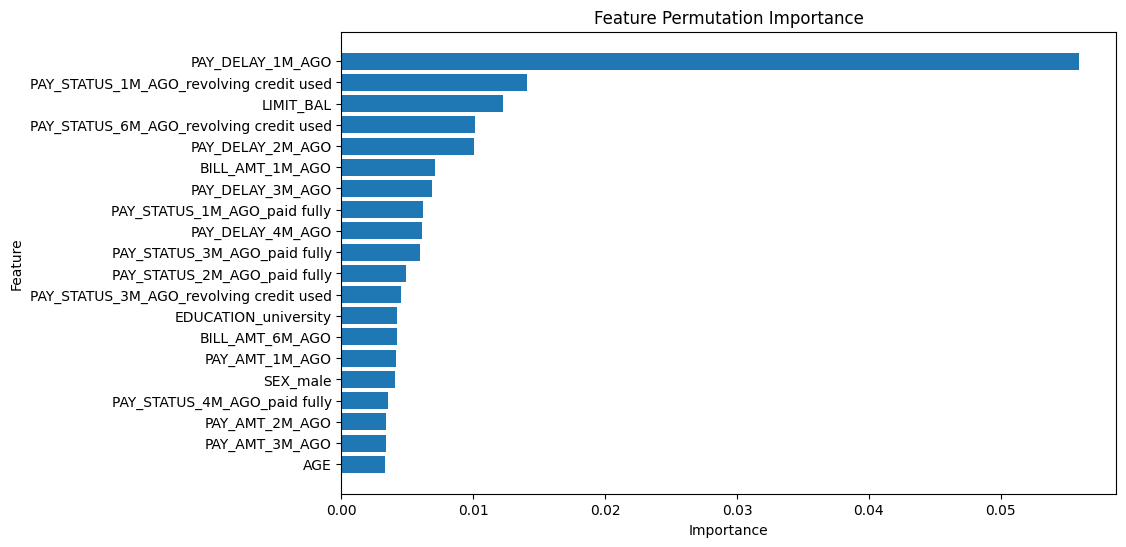

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'PAY_STATUS_6M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITER

In [ ]:
et2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   827  3839  834   500      49.79   62.32        82.15     77.77     55.35   
1   694  4008  665   633      51.07   52.30        85.77     78.37     51.68   
2   688  4011  662   639      50.96   51.85        85.83     78.32     51.40   
3   674  4053  620   653      52.09   50.79        86.73     78.78     51.43   
4   659  4084  589   668      52.80   49.66        87.40     79.05     51.18   
5   479  4261  412   848      53.76   36.10        91.18     79.00     43.19   
6   476  4262  411   851      53.66   35.87        91.20     78.97     43.00   
7   383  4361  312   944      55.11   28.86        93.32     79.07     37.88   
8    42  4650   23  1285      64.62    3.17        99.51     78.20      6.03   
9   180  4585   88  1147      67.16   13.56        98.12     79.42     22.57   
10  182  4583   90  1145      66.91   13.72        98.07     79.42     22.76   
11  181  4588   85  1146      68.05   13.64        98.18     79.48     22.72   
12  201  4574   99  1126      67.00   15.15        97.88     79.58     24.71   
13  180  4585   88  1147      67.16   13.56        98.12     79.42     22.57   
14  115  4613   60  1212      65.71    8.67        98.72     78.80     15.31   
15  129  4605   68  1198      65.48    9.72        98.54     78.90     16.93   
16  128  4605   68  1199      65.31    9.65        98.54     78.88     16.81   
17  130  4605   68  1197      65.66    9.80        98.54     78.92     17.05   
18  129  4605   68  1198      65.48    9.72        98.54     78.90     16.93   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.24                 0   
1               69.03                 1   
2               68.84                 2   
3               68.76                 3   
4               68.53                 4   
5               63.64                 5   
6               63.54                 6   
7               61.09                 7   
8               51.34                 8   
9               55.84                 9   
10              55.89                10   
11              55.91                11   
12              56.51                12   
13              55.84                13   
14              53.69                14   
15              54.13                15   
16              54.10                16   
17              54.17                17   
18              54.13                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:36:23.359712

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
et2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   827  3839  834   500      49.79   62.32        82.15     77.77     55.35   
1   742  3872  801   585      48.09   55.92        82.86     76.90     51.71   
2   696  3932  741   631      48.43   52.45        84.14     77.13     50.36   
3   688  3964  709   639      49.25   51.85        84.83     77.53     50.51   
4   671  4000  673   656      49.93   50.57        85.60     77.85     50.24   
5   585  4046  627   742      48.27   44.08        86.58     77.18     46.08   
6   526  4192  481   801      52.23   39.64        89.71     78.63     45.07   
7   429  4304  369   898      53.76   32.33        92.10     78.88     40.38   
8   342  4435  238   985      58.97   25.77        94.91     79.62     35.87   
9   329  4452  221   998      59.82   24.79        95.27     79.68     35.06   
10  327  4453  220  1000      59.78   24.64        95.29     79.67     34.90   
11  323  4453  220  1004      59.48   24.34        95.29     79.60     34.55   
12  324  4456  217  1003      59.89   24.42        95.36     79.67     34.69   
13  322  4464  209  1005      60.64   24.27        95.53     79.77     34.66   
14  316  4468  205  1011      60.65   23.81        95.61     79.73     34.20   
15  295  4482  191  1032      60.70   22.23        95.91     79.62     32.54   
16  291  4482  191  1036      60.37   21.93        95.91     79.55     32.17   
17  279  4494  179  1048      60.92   21.02        96.17     79.55     31.26   
18  275  4508  165  1052      62.50   20.72        96.47     79.72     31.13   
19  278  4501  172  1049      61.78   20.95        96.32     79.65     31.29   
20  271  4509  164  1056      62.30   20.42        96.49     79.67     30.76   

    balanced_accuracy  num_feat_missing  \
0               72.24                 0   
1               69.39                 1   
2               68.30                 2   
3               68.34                 3   
4               68.08                 4   
5               65.33                 5   
6               64.67                 6   
7               62.22                 7   
8               60.34                 8   
9               60.03                 9   
10              59.97                10   
11              59.82                11   
12              59.89                12   
13              59.90                13   
14              59.71                14   
15              59.07                15   
16              58.92                16   
17              58.60                17   
18              58.60                18   
19              58.63                19   
20              58.46                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
et2_perf_temp, et2_orig_missing_temp, et2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
et2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  827  3839  834   500      49.79   62.32        82.15     77.77     55.35   
1  665  4055  618   662      51.83   50.11        86.78     78.67     50.96   
2  665  4055  618   662      51.83   50.11        86.78     78.67     50.96   
3  642  4090  583   685      52.41   48.38        87.52     78.87     50.31   
4  441  4289  384   886      53.45   33.23        91.78     78.83     40.99   
5  398  4336  337   929      54.15   29.99        92.79     78.90     38.60   
6   33  4659   14  1294      70.21    2.49        99.70     78.20      4.80   
7   18  4663   10  1309      64.29    1.36        99.79     78.02      2.66   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.24                 0   
1              68.44                 4   
2              68.44                 5   
3              67.95                 9   
4              62.51                12   
5              61.39                15   
6              51.09                18   
7              50.57                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_temp_mf, et2_orig_missing_temp_mf, et2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:41:28.271151

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
et2_perf_temp_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  827  3839  834  500      49.79   62.32        82.15     77.77     55.35   
1  619  4114  559  708      52.55   46.65        88.04     78.88     49.42   
2  602  4150  523  725      53.51   45.37        88.81     79.20     49.10   
3  589  4168  505  738      53.84   44.39        89.19     79.28     48.66   
4  507  4200  473  820      51.73   38.21        89.88     78.45     43.95   
5  378  4366  307  949      55.18   28.49        93.43     79.07     37.57   
6  340  4434  239  987      58.72   25.62        94.89     79.57     35.68   
7  350  4430  243  977      59.02   26.38        94.80     79.67     36.46   
8  348  4430  243  979      58.88   26.22        94.80     79.63     36.29   

   balanced_accuracy  num_feat_missing  \
0              72.24                 0   
1              67.34                 4   
2              67.09                 5   
3              66.79                 9   
4              64.04                12   
5              60.96                15   
6              60.25                18   
7              60.59                19   
8              60.51                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1],
  }
else:
  # best model
  svm2_param_grid = {
      'C': [5.0],
      'kernel': ['rbf'],
      'gamma': [0.1]
}

svm2_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy',
    X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 19:43:25.419054

Nested Cross-validation Results:
Individual scores: [0.70095365 0.68435536 0.68835823]
Average nested CV score: 0.691 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.691
2025-01-18 19:45:15.347193

Execution time: 1.83 minutes


```
Starting hyperparameter tuning at: 2025-01-17 10:17:07.387604

Nested Cross-validation Results:
Individual scores: [0.70095365 0.68435536 0.68835823]
Average nested CV score: 0.691 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.691
2025-01-17 10:36:07.531820

Execution time: 19.00 minutes
```

In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(
    svm2_classifier, X_train_scaled, y_train,
    scoring_metric="balanced_accuracy", n_repeats=3
)
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
6   PAY_STATUS_1M_AGO_revolving credit used    0.081981  0.002269
10  PAY_STATUS_3M_AGO_revolving credit used    0.041902  0.001416
0                          PAY_DELAY_1M_AGO    0.017072  0.000140
22             PAY_STATUS_1M_AGO_paid fully    0.008395  0.000727
19             PAY_STATUS_2M_AGO_paid fully    0.005756  0.000410
26                                 SEX_male    0.003657  0.000399
18             PAY_STATUS_3M_AGO_paid fully    0.003603  0.000078
16  PAY_STATUS_5M_AGO_revolving credit used    0.003447  0.000950
20             PAY_STATUS_4M_AGO_paid fully    0.002974  0.000285
29                          MARRIAGE_single    0.002716  0.000588
27                    EDUCATION_high school    0.002345  0.000513
17  PAY_STATUS_6M_AGO_revolving credit used    0.002061  0.000723
25                     EDUCATION_university    0.001919  0.000700
7                                 LIMIT_BAL    0.001874  0.000763
24                         EDUCATION_others    0.001857  0.000057
1                          PAY_DELAY_2M_AGO    0.001755  0.000386
21             PAY_STATUS_5M_AGO_paid fully    0.001658  0.000955
12  PAY_STATUS_4M_AGO_revolving credit used    0.001561  0.000504
23             PAY_STATUS_6M_AGO_paid fully    0.001498  0.000618
30                                      AGE    0.001489  0.000272
2                          PAY_DELAY_3M_AGO    0.001107  0.000715
3                          PAY_DELAY_4M_AGO    0.000708  0.000698
4                          PAY_DELAY_5M_AGO    0.000704  0.000452
15                           PAY_AMT_6M_AGO    0.000356  0.000237
11                           PAY_AMT_3M_AGO    0.000342  0.000060
14                           PAY_AMT_5M_AGO    0.000160  0.000284
13                           PAY_AMT_4M_AGO    0.000131  0.000034
28                          BILL_AMT_1M_AGO    0.000116  0.000085
32                          MARRIAGE_others    0.000058  0.000064
9                            PAY_AMT_1M_AGO   -0.000025  0.000094
8                            PAY_AMT_2M_AGO   -0.000079  0.000153
5                          PAY_DELAY_6M_AGO   -0.000194  0.000469
31                          BILL_AMT_6M_AGO   -0.000450  0.000252

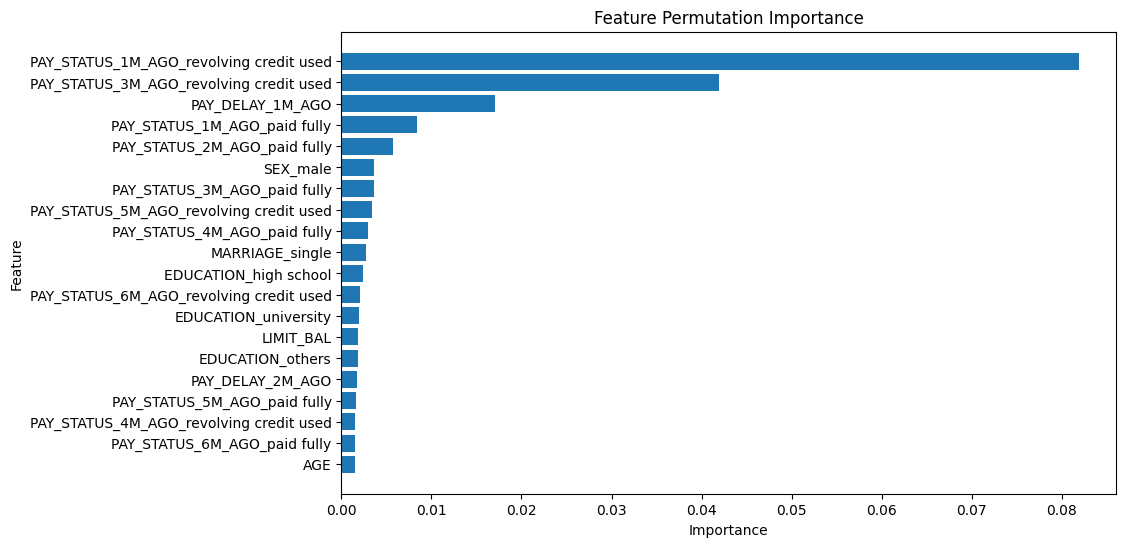

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_paid fully
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  SEX_male
Removing related features: 

In [ ]:
svm2_perf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    772  3961   712  555      52.02   58.18        84.76     78.88     54.93   
1   1005  1893  2780  322      26.55   75.73        40.51     48.30     39.32   
2   1141  1397  3276  186      25.83   85.98        29.90     42.30     39.73   
3   1078  1595  3078  249      25.94   81.24        34.13     44.55     39.32   
4   1094  1413  3260  233      25.13   82.44        30.24     41.78     38.51   
5   1072  1503  3170  255      25.27   80.78        32.16     42.92     38.50   
6   1150  1060  3613  177      24.14   86.66        22.68     36.83     37.77   
7   1190   855  3818  137      23.76   89.68        18.30     34.08     37.57   
8   1260   514  4159   67      23.25   94.95        11.00     29.57     37.36   
9   1250   548  4125   77      23.26   94.20        11.73     29.97     37.30   
10  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
11  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
12  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
13  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
14  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
15  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
16  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
17  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
18  1327     3  4670    0      22.13  100.00         0.06     22.17     36.24   
19  1327     2  4671    0      22.12  100.00         0.04     22.15     36.23   
20  1327     2  4671    0      22.12  100.00         0.04     22.15     36.23   

    balanced_accuracy  num_feat_missing  \
0               71.47                 0   
1               58.12                 1   
2               57.94                 2   
3               57.68                 3   
4               56.34                 4   
5               56.47                 5   
6               54.67                 6   
7               53.99                 7   
8               52.98                 8   
9               52.96                 9   
10              50.03                10   
11              50.03                11   
12              50.03                12   
13              50.03                13   
14              50.03                14   
15              50.03                15   
16              50.03                16   
17              50.03                17   
18              50.03                18   
19              50.02                19   
20              50.02                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 19:55:02.735155

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  2
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUC

In [ ]:
svm2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   772  3961  712   555      52.02   58.18        84.76     78.88     54.93   
1   601  4111  562   726      51.68   45.29        87.97     78.53     48.27   
2   559  4236  437   768      56.12   42.13        90.65     79.92     48.13   
3   533  4249  424   794      55.69   40.17        90.93     79.70     46.67   
4   521  4303  370   806      58.47   39.26        92.08     80.40     46.98   
5   519  4295  378   808      57.86   39.11        91.91     80.23     46.67   
6   508  4298  375   819      57.53   38.28        91.98     80.10     45.97   
7   481  4375  298   846      61.75   36.25        93.62     80.93     45.68   
8   486  4370  303   841      61.60   36.62        93.52     80.93     45.94   
9   491  4372  301   836      61.99   37.00        93.56     81.05     46.34   
10  470  4378  295   857      61.44   35.42        93.69     80.80     44.93   
11  469  4379  294   858      61.47   35.34        93.71     80.80     44.88   
12  376  4419  254   951      59.68   28.33        94.56     79.92     38.43   
13  373  4424  249   954      59.97   28.11        94.67     79.95     38.28   
14  324  4459  214  1003      60.22   24.42        95.42     79.72     34.75   
15  243  4531  142  1084      63.12   18.31        96.96     79.57     28.39   
16   30  4668    5  1297      85.71    2.26        99.89     78.30      4.41   
17   31  4665    8  1296      79.49    2.34        99.83     78.27      4.54   
18   33  4664    9  1294      78.57    2.49        99.81     78.28      4.82   
19   31  4666    7  1296      81.58    2.34        99.85     78.28      4.54   
20   23  4669    4  1304      85.19    1.73        99.91     78.20      3.40   

    balanced_accuracy  num_feat_missing  \
0               71.47                 0   
1               66.63                 1   
2               66.39                 2   
3               65.55                 3   
4               65.67                 4   
5               65.51                 5   
6               65.13                 6   
7               64.94                 7   
8               65.07                 8   
9               65.28                 9   
10              64.55                10   
11              64.53                11   
12              61.45                12   
13              61.39                13   
14              59.92                14   
15              57.64                15   
16              51.08                16   
17              51.08                17   
18              51.15                18   
19              51.09                19   
20              50.82                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm2_perf_temp, svm2_orig_missing_temp, svm2_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO    

In [ ]:
svm2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  772  3961  712   555      52.02   58.18        84.76     78.88     54.93   
1    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
2    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
3    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
4    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
9    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.47                 0   
1              50.00                 4   
2              50.00                 7   
3              50.00                10   
4              50.00                11   
5              50.00                14   
6              50.00                17   
7              50.00                18   
8              50.00                19   
9              50.00                23   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
9  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_temp_mf, svm2_orig_missing_temp_mf, svm2_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:02:42.198606

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']


In [ ]:
svm2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  772  3961  712   555      52.02   58.18        84.76     78.88     54.93   
1  568  4153  520   759      52.21   42.80        88.87     78.68     47.04   
2  532  4252  421   795      55.82   40.09        90.99     79.73     46.67   
3  343  4412  261   984      56.79   25.85        94.41     79.25     35.53   
4  346  4399  274   981      55.81   26.07        94.14     79.08     35.54   
5  302  4409  264  1025      53.36   22.76        94.35     78.52     31.91   
6   19  4669    4  1308      82.61    1.43        99.91     78.13      2.81   
7   24  4668    5  1303      82.76    1.81        99.89     78.20      3.54   
8   24  4668    5  1303      82.76    1.81        99.89     78.20      3.54   
9    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.47                 0   
1              65.84                 4   
2              65.54                 7   
3              60.13                10   
4              60.11                11   
5              58.55                14   
6              50.67                17   
7              50.85                18   
8              50.85                19   
9              50.00                23   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
9  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [5.0],
      'penalty': ['l2'],
      'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 20:05:56.161308

Nested Cross-validation Results:
Individual scores: [0.71100423 0.69807792 0.69871045]
Average nested CV score: 0.703 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'penalty': 'l2', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.703
2025-01-18 20:06:01.646336

Execution time: 0.09 minutes


```
Starting hyperparameter tuning at: 2025-01-17 07:48:59.022735

Nested Cross-validation Results:
Individual scores: [0.71052277 0.69706677 0.69850822]
Average nested CV score: 0.702 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.703
2025-01-17 07:49:21.724569

Execution time: 0.38 minutes
```

In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.092294  0.003146
7                                 LIMIT_BAL    0.012037  0.000544
2                          PAY_DELAY_3M_AGO    0.007195  0.000881
22             PAY_STATUS_1M_AGO_paid fully    0.004830  0.000476
3                          PAY_DELAY_4M_AGO    0.003485  0.000694
28                          BILL_AMT_1M_AGO    0.003387  0.001494
19             PAY_STATUS_2M_AGO_paid fully    0.001493  0.000387
17  PAY_STATUS_6M_AGO_revolving credit used    0.001378  0.001024
26                                 SEX_male    0.001260  0.000964
10  PAY_STATUS_3M_AGO_revolving credit used    0.001249  0.000171
24                         EDUCATION_others    0.001179  0.000677
6   PAY_STATUS_1M_AGO_revolving credit used    0.000999  0.001032
14                           PAY_AMT_5M_AGO    0.000929  0.000305
29                          MARRIAGE_single    0.000911  0.000762
23             PAY_STATUS_6M_AGO_paid fully    0.000809  0.000262
21             PAY_STATUS_5M_AGO_paid fully    0.000759  0.000121
5                          PAY_DELAY_6M_AGO    0.000694  0.000198
27                    EDUCATION_high school    0.000693  0.000108
9                            PAY_AMT_1M_AGO    0.000507  0.000566
11                           PAY_AMT_3M_AGO    0.000437  0.000253
15                           PAY_AMT_6M_AGO    0.000349  0.000587
20             PAY_STATUS_4M_AGO_paid fully    0.000316  0.000475
31                          BILL_AMT_6M_AGO    0.000302  0.000262
32                          MARRIAGE_others    0.000290  0.000209
8                            PAY_AMT_2M_AGO    0.000282  0.000457
18             PAY_STATUS_3M_AGO_paid fully    0.000252  0.000139
4                          PAY_DELAY_5M_AGO    0.000235  0.000150
30                                      AGE    0.000153  0.000269
13                           PAY_AMT_4M_AGO    0.000018  0.000165
25                     EDUCATION_university   -0.000007  0.000178
1                          PAY_DELAY_2M_AGO   -0.000093  0.000260
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000328  0.000419
16  PAY_STATUS_5M_AGO_revolving credit used   -0.000466  0.000620

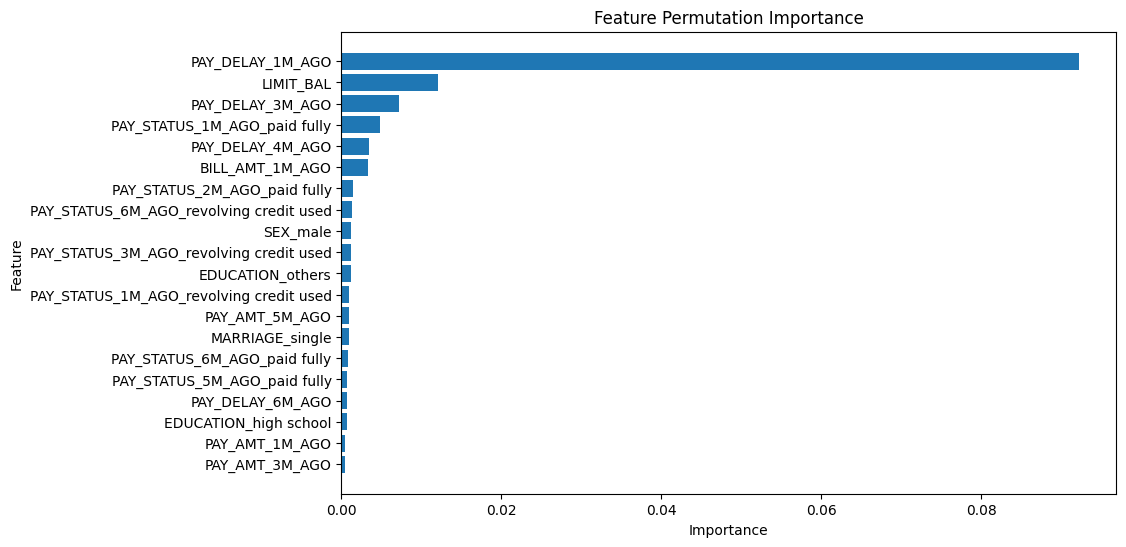

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO'

In [ ]:
lr2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879  794   520      50.41   60.81        83.01     78.10     55.12   
1   482  4257  416   845      53.67   36.32        91.10     78.98     43.33   
2   444  4288  385   883      53.56   33.46        91.76     78.87     41.19   
3   332  4383  290   995      53.38   25.02        93.79     78.58     34.07   
4   331  4379  294   996      52.96   24.94        93.71     78.50     33.91   
5   242  4435  238  1085      50.42   18.24        94.91     77.95     26.78   
6   176  4515  158  1151      52.69   13.26        96.62     78.18     21.19   
7   179  4503  170  1148      51.29   13.49        96.36     78.03     21.36   
8    24  4662   11  1303      68.57    1.81        99.76     78.10      3.52   
9    14  4673    0  1313     100.00    1.06       100.00     78.12      2.09   
10   17  4673    0  1310     100.00    1.28       100.00     78.17      2.53   
11   13  4673    0  1314     100.00    0.98       100.00     78.10      1.94   
12   13  4673    0  1314     100.00    0.98       100.00     78.10      1.94   
13   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
14   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.91                 0   
1               63.71                 1   
2               62.61                 2   
3               59.41                 3   
4               59.33                 4   
5               56.57                 5   
6               54.94                 6   
7               54.93                 7   
8               50.79                 8   
9               50.53                 9   
10              50.64                10   
11              50.49                11   
12              50.49                12   
13              50.45                13   
14              50.45                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)


print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:06:04.720139

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879  794  520      50.41   60.81        83.01     78.10     55.12   
1   758  3811  862  569      46.79   57.12        81.55     76.15     51.44   
2   748  3862  811  579      47.98   56.37        82.64     76.83     51.84   
3   742  3846  827  585      47.29   55.92        82.30     76.47     51.24   
4   708  3899  774  619      47.77   53.35        83.44     76.78     50.41   
5   691  3944  729  636      48.66   52.07        84.40     77.25     50.31   
6   667  4045  628  660      51.51   50.26        86.56     78.53     50.88   
7   645  4093  580  682      52.65   48.61        87.59     78.97     50.55   
8   632  4128  545  695      53.70   47.63        88.34     79.33     50.48   
9   627  4170  503  700      55.49   47.25        89.24     79.95     51.04   
10  584  4240  433  743      57.42   44.01        90.73     80.40     49.83   
11  579  4259  414  748      58.31   43.63        91.14     80.63     49.91   
12  581  4258  415  746      58.33   43.78        91.12     80.65     50.02   
13  585  4257  416  742      58.44   44.08        91.10     80.70     50.26   
14  576  4290  383  751      60.06   43.41        91.80     81.10     50.39   
15  541  4340  333  786      61.90   40.77        92.87     81.35     49.16   
16  554  4312  361  773      60.55   41.75        92.27     81.10     49.42   
17  552  4309  364  775      60.26   41.60        92.21     81.02     49.22   
18  550  4310  363  777      60.24   41.45        92.23     81.00     49.11   
19  551  4308  365  776      60.15   41.52        92.19     80.98     49.13   
20  554  4306  367  773      60.15   41.75        92.15     81.00     49.29   

    balanced_accuracy  num_feat_missing  \
0               71.91                 0   
1               69.34                 1   
2               69.51                 2   
3               69.11                 3   
4               68.40                 4   
5               68.24                 5   
6               68.41                 6   
7               68.10                 7   
8               67.98                 8   
9               68.24                 9   
10              67.37                10   
11              67.39                11   
12              67.45                12   
13              67.59                13   
14              67.61                14   
15              66.82                15   
16              67.01                16   
17              66.90                17   
18              66.84                18   
19              66.86                19   
20              66.95                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr2_perf_temp, lr2_orig_missing_temp, lr2_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879   794   520      50.41   60.81        83.01     78.10     55.12   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.91                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                11   
5              50.00                14   
6              50.00                18   
7              50.00                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_temp_mf, lr2_orig_missing_temp_mf, lr2_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 20:11:36.284720

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr2_perf_temp_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  807  3879  794  520      50.41   60.81        83.01     78.10     55.12   
1  692  3928  745  635      48.16   52.15        84.06     77.00     50.07   
2  706  3906  767  621      47.93   53.20        83.59     76.87     50.43   
3  642  4119  554  685      53.68   48.38        88.14     79.35     50.89   
4  643  4109  564  684      53.27   48.46        87.93     79.20     50.75   
5  345  4393  280  982      55.20   26.00        94.01     78.97     35.35   
6  364  4382  291  963      55.57   27.43        93.77     79.10     36.73   
7  365  4388  285  962      56.15   27.51        93.90     79.22     36.92   
8  351  4431  242  976      59.19   26.45        94.82     79.70     36.56   

   balanced_accuracy  num_feat_missing  \
0              71.91                 0   
1              68.10                 4   
2              68.39                 5   
3              68.26                 8   
4              68.19                11   
5              60.00                14   
6              60.60                18   
7              60.70                19   
8              60.64                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Results comparison - Standard Scenario**



## **F1-score**

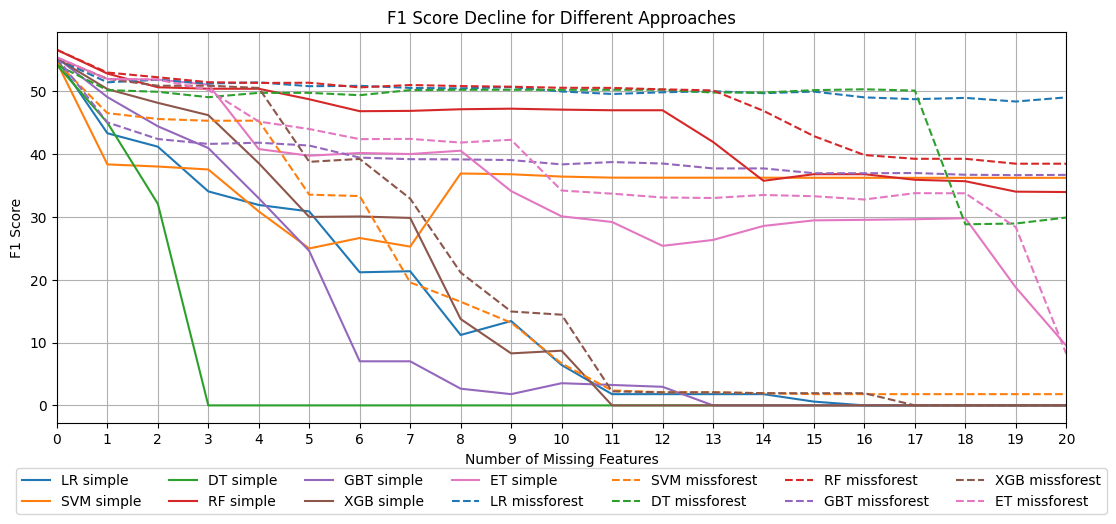

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

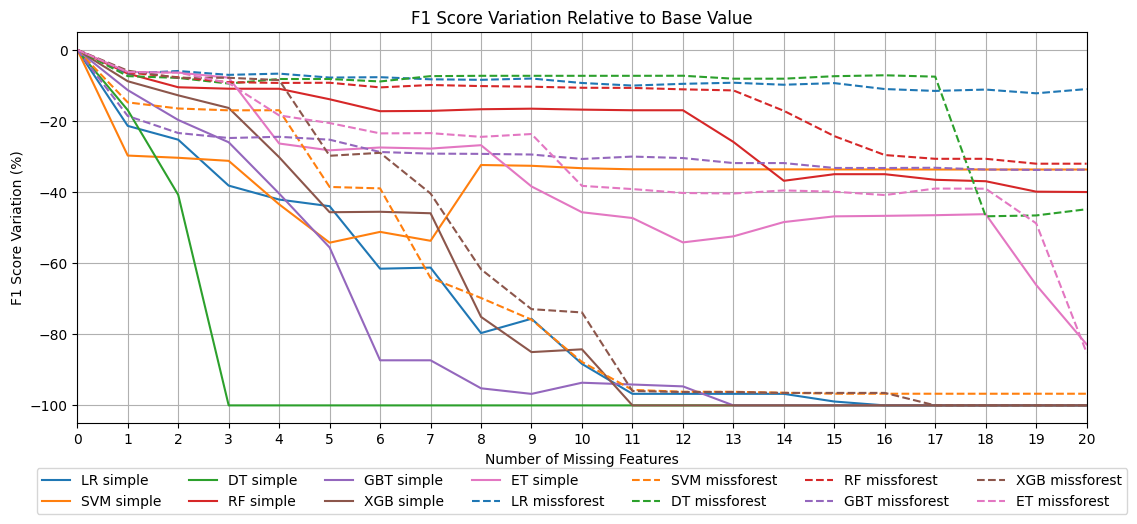

In [ ]:
# Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced accuracy**

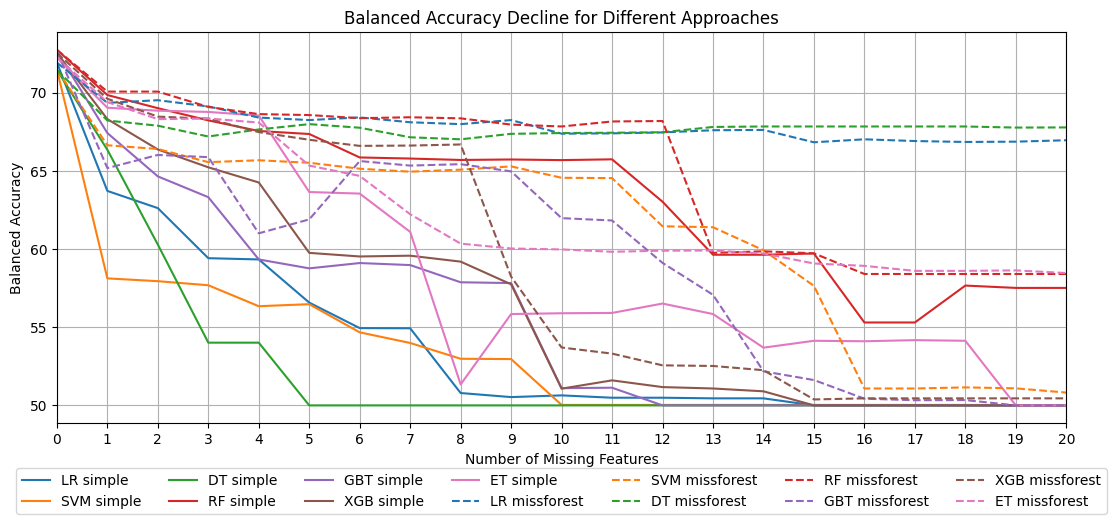

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

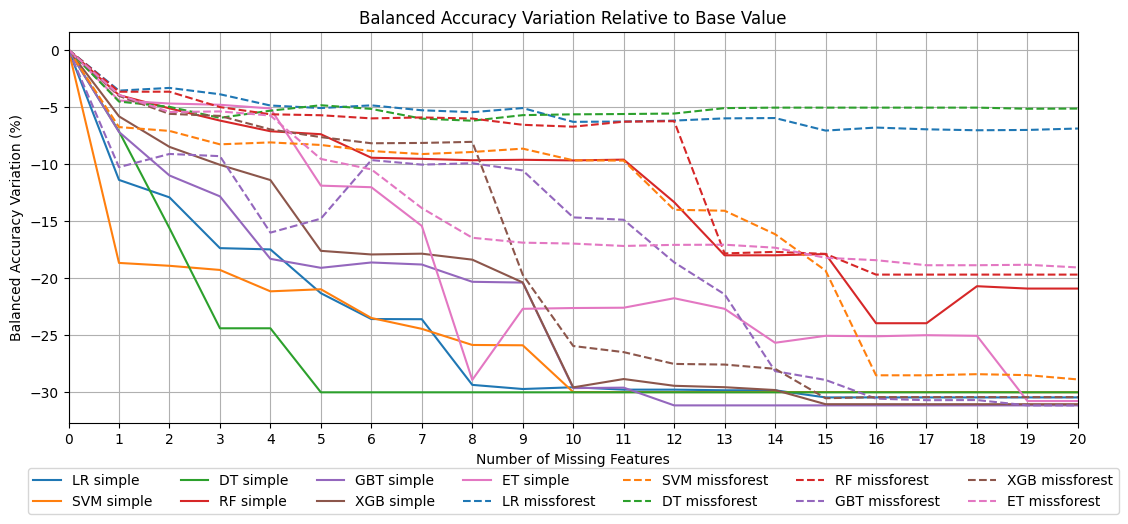

In [ ]:
# Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this dataset there are few highly correlated variables (even considerind the ohe). So the ensemble models like Random Forests and Extra Trees do not benefit from the power of backup variables because they actually do not exist.

From the analysis of F1 and Balanced Accuracy, Decision Trees and XGBoost seem to be the less resilient to features missing.

# **Results comparison - Temporal Scenario**

## **F1-score**

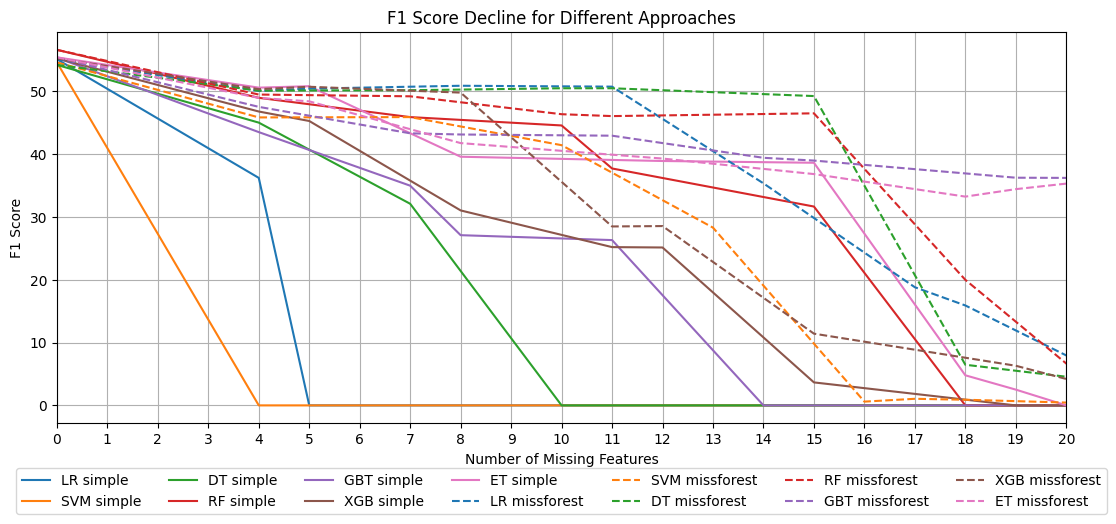

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf_temp['num_feat_missing'], lr_perf_temp['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf_temp['num_feat_missing'], svm_perf_temp['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf_temp['num_feat_missing'], dt_perf_temp['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf_temp['num_feat_missing'], rf_perf_temp['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf_temp['num_feat_missing'], gbt_perf_temp['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf_temp['num_feat_missing'], xgb_perf_temp['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf_temp['num_feat_missing'], et_perf_temp['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_temp_mf['num_feat_missing'], lr_perf_temp_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_temp_mf['num_feat_missing'], svm_perf_temp_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_temp_mf['num_feat_missing'], dt_perf_temp_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_temp_mf['num_feat_missing'], rf_perf_temp_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_temp_mf['num_feat_missing'], gbt_perf_temp_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_temp_mf['num_feat_missing'], xgb_perf_temp_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_temp_mf['num_feat_missing'], et_perf_temp_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

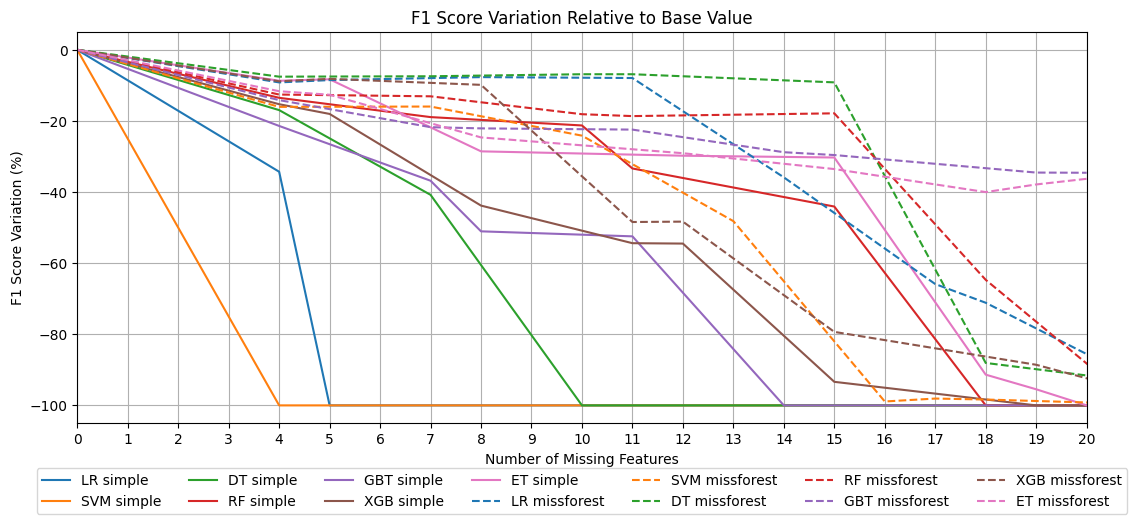

In [ ]:
# # Line plot for the f1 score variation relative to the base value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf_temp, svm_perf_temp, dt_perf_temp, rf_perf_temp, gbt_perf_temp, xgb_perf_temp, et_perf_temp,
     lr_perf_temp_mf, svm_perf_temp_mf, dt_perf_temp_mf, rf_perf_temp_mf, gbt_perf_temp_mf, xgb_perf_temp_mf, et_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Balanced accuracy**

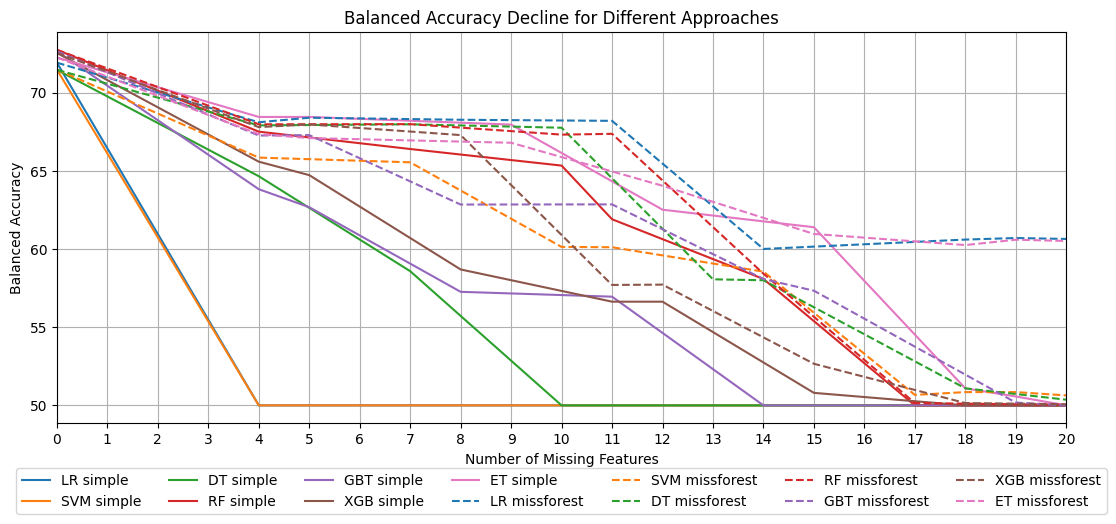

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf_temp['num_feat_missing'], lr2_perf_temp['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf_temp['num_feat_missing'], svm2_perf_temp['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf_temp['num_feat_missing'], dt2_perf_temp['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf_temp['num_feat_missing'], rf2_perf_temp['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf_temp['num_feat_missing'], gbt2_perf_temp['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf_temp['num_feat_missing'], xgb2_perf_temp['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf_temp['num_feat_missing'], et2_perf_temp['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_temp_mf['num_feat_missing'], lr2_perf_temp_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_temp_mf['num_feat_missing'], svm2_perf_temp_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_temp_mf['num_feat_missing'], dt2_perf_temp_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_temp_mf['num_feat_missing'], rf2_perf_temp_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_temp_mf['num_feat_missing'], gbt2_perf_temp_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_temp_mf['num_feat_missing'], xgb2_perf_temp_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_temp_mf['num_feat_missing'], et2_perf_temp_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

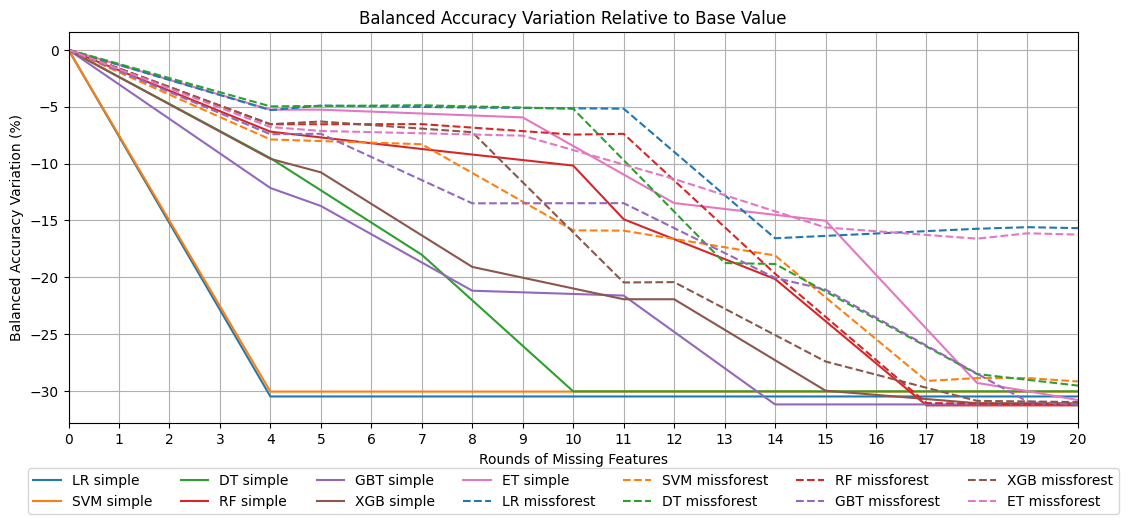

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the balanced accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf_temp, svm2_perf_temp, dt2_perf_temp, rf2_perf_temp, gbt2_perf_temp, xgb2_perf_temp, et2_perf_temp,
     lr2_perf_temp_mf, svm2_perf_temp_mf, dt2_perf_temp_mf, rf2_perf_temp_mf, gbt2_perf_temp_mf, xgb2_perf_temp_mf, et2_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base balanced accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Rounds of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf
}

all_data = combine_datasets(
    dataset_dict,
    'Default Credit Card',  'Scenario 2: drop intercorrelated',
    RANDOM_STATE
)
save_dataset(all_data, 'default_cc_scenario2_seed_1981.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset_temp_dict = {
    'lr_perf_temp': lr_perf_temp,
    'svm_perf_temp': svm_perf_temp,
    'dt_perf_temp': dt_perf_temp,
    'rf_perf_temp': rf_perf_temp,
    'gbt_perf_temp': gbt_perf_temp,
    'xgb_perf_temp': xgb_perf_temp,
    'et_perf_temp': et_perf_temp,
    'lr_perf_temp_mf': lr_perf_temp_mf,
    'svm_perf_temp_mf': svm_perf_temp_mf,
    'dt_perf_temp_mf': dt_perf_temp_mf,
    'rf_perf_temp_mf': rf_perf_temp_mf,
    'gbt_perf_temp_mf': gbt_perf_temp_mf,
    'xgb_perf_temp_mf': xgb_perf_temp_mf,
    'et_perf_temp_mf': et_perf_temp_mf,
    'lr2_perf_temp': lr2_perf_temp,
    'svm2_perf_temp': svm2_perf_temp,
    'dt2_perf_temp': dt2_perf_temp,
    'rf2_perf_temp': rf2_perf_temp,
    'gbt2_perf_temp': gbt2_perf_temp,
    'xgb2_perf_temp': xgb2_perf_temp,
    'et2_perf_temp': et2_perf_temp,
    'lr2_perf_temp_mf': lr2_perf_temp_mf,
    'svm2_perf_temp_mf': svm2_perf_temp_mf,
    'dt2_perf_temp_mf': dt2_perf_temp_mf,
    'rf2_perf_temp_mf': rf2_perf_temp_mf,
    'gbt2_perf_temp_mf': gbt2_perf_temp_mf,
    'xgb2_perf_temp_mf': xgb2_perf_temp_mf,
    'et2_perf_temp_mf': et2_perf_temp_mf
}

all_data_temp = combine_datasets(
    dataset_temp_dict,
    'Default Credit Card Temporal',  'Scenario 2: drop intercorrelated',
    RANDOM_STATE
)
save_dataset(all_data_temp, 'default_cc_temp_scenario2_seed_1981.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0    807  3879  794   520      50.41   60.81        83.01     78.10     55.12   
1    482  4257  416   845      53.67   36.32        91.10     78.98     43.33   
2    444  4288  385   883      53.56   33.46        91.76     78.87     41.19   
3    332  4383  290   995      53.38   25.02        93.79     78.58     34.07   
4    306  4388  285  1021      51.78   23.06        93.90     78.23     31.91   
..   ...   ...  ...   ...        ...     ...          ...       ...       ...   
583  291  4482  191  1036      60.37   21.93        95.91     79.55     32.17   
584  279  4494  179  1048      60.92   21.02        96.17     79.55     31.26   
585  275  4508  165  1052      62.50   20.72        96.47     79.72     31.13   
586  278  4501  172  1049      61.78   20.95        96.32     79.65     31.29   
587  271  4509  164  1056      62.30   20.42        96.49     79.67     30.76   

     balanced_accuracy  num_feat_missing  \
0                71.91                 0   
1                63.71                 1   
2                62.61                 2   
3                59.41                 3   
4                58.48                 4   
..                 ...               ...   
583              58.92                16   
584              58.60                17   
585              58.60                18   
586              58.63                19   
587              58.46                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                         ['PAY_DELAY_1M_AGO'] imputed      lr_perf   
2            ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed      lr_perf   
3    ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...      lr_perf   
4    ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...      lr_perf   
..                                                 ...          ...   
583  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   
584  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   
585  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   
586  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   
587  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  et2_perf_mf   

                  source                          scenario  random_state  \
0    Default Credit Card  Scenario 2: drop intercorrelated          1981   
1    Default Credit Card  Scenario 2: drop intercorrelated          1981   
2    Default Credit Card  Scenario 2: drop intercorrelated          1981   
3    Default Credit Card  Scenario 2: drop intercorrelated          1981   
4    Default Credit Card  Scenario 2: drop intercorrelated          1981   
..                   ...                               ...           ...   
583  Default Credit Card  Scenario 2: drop intercorrelated          1981   
584  Default Credit Card  Scenario 2: drop intercorrelated          1981   
585  Default Credit Card  Scenario 2: drop intercorrelated          1981   
586  Default Credit Card  Scenario 2: drop intercorrelated          1981   
587  Default Credit Card  Scenario 2: drop intercorrelated          1981   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]

In [ ]:
all_data_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  \
0     807  3879   794   520      50.41   60.81        83.01     78.10   
1    1327     0  4673     0      22.12  100.00         0.00     22.12   
2       0  4673     0  1327       0.00    0.00       100.00     77.88   
3       0  4673     0  1327       0.00    0.00       100.00     77.88   
4       0  4673     0  1327       0.00    0.00       100.00     77.88   
..    ...   ...   ...   ...        ...     ...          ...       ...   
241   507  4200   473   820      51.73   38.21        89.88     78.45   
242   378  4366   307   949      55.18   28.49        93.43     79.07   
243   340  4434   239   987      58.72   25.62        94.89     79.57   
244   350  4430   243   977      59.02   26.38        94.80     79.67   
245   348  4430   243   979      58.88   26.22        94.80     79.63   

     f1_score  balanced_accuracy  num_feat_missing  \
0       55.12              71.91                 0   
1       36.22              50.00                 4   
2        0.00              50.00                 5   
3        0.00              50.00                 8   
4        0.00              50.00                11   
..        ...                ...               ...   
241     43.95              64.04                12   
242     37.57              60.96                15   
243     35.68              60.25                18   
244     36.46              60.59                19   
245     36.29              60.51                20   

                                               imputed           dataset  \
0                                                           lr_perf_temp   
1    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
2    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
3    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
4    ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...      lr_perf_temp   
..                                                 ...               ...   
241  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
242  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
243  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
244  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   
245  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  et2_perf_temp_mf   

                           source                          scenario  \
0    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
1    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
2    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
3    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
4    Default Credit Card Temporal  Scenario 2: drop intercorrelated   
..                            ...                               ...   
241  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
242  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
243  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
244  Default Credit Card Temporal  Scenario 2: drop intercorrelated   
245  Default Credit Card Temporal  Scenario 2: drop intercorrelated   

     random_state             metric  
0            1981           f1 score  
1            1981           f1 score  
2            1981           f1 score  
3            1981           f1 score  
4            1981           f1 score  
..            ...                ...  
241          1981  balanced accuracy  
242          1981  balanced accuracy  
243          1981  balanced accuracy  
244          1981  balanced accuracy  
245          1981  balanced accuracy  

[246 rows x 17 columns]